In [64]:
import pandas
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from scipy import stats
from sklearn import model_selection, linear_model
from scipy import ndimage
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import calinski_harabaz_score
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering, SpectralClustering
from statsmodels.nonparametric.smoothers_lowess import lowess

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
git_dir = '/home/users/jvogel/git/Hippocampus_AP_Axis/'

import sys
sys.path.insert(0,git_dir)
import HAP_Utils as hap

# Get hippocampus samples
Note: The spreadheets below are generated in NB1, or in the case of "probes", are straight from the Allen Brain Atlas dataset

In [5]:
wdir = os.path.join(git_dir, 'Data')
aba_dir = '/data1/users/jvogel/Allen_Human_Brain_Atlas/'

df = pandas.read_csv(os.path.join(wdir,'MAIN_hippocampus_sample_info.csv'),index_col=0)
xp = pandas.read_csv(os.path.join(wdir,'MAIN_hippocampus_gxp.csv'),index_col=0)
gdf = pandas.read_csv(os.path.join(wdir,'MAIN_gcx_wholebrain_info.csv'))
probes = pandas.read_csv(os.path.join(aba_dir,'normalized_microarray_donor9861/Probes.csv'))

In [4]:
# Uncomment if you want to save figures to disk
# fig_dir = 

# Run main analysis pipeline to get variables

In [6]:
pcalr_out_NEW = hap.PCA_LR_pipeline(xp.values.T, 
                            (df.position_along_hipp_AP_axis), 
                            cv_strategy='score', illustrative=False,
                           test_gene_num = [100],
                               sanity_check_style = 'model')

running PCA
transforming data
performing model cross-validation
using basic 10-fold cross-validation
model cv score: r2 =  0.6758859774822009
running final model
final model fit r2 =  0.8768105093258057
running sanity_check


# Examining the stability of model after removing genes

In [9]:
### THIS TAKES AWHILE -- I RUN IT OVERNIGHT, ALONG WITH THE NEXT ONE

# RERUNNING MODEL AFTER REMOVING TOP 50 ANTERIOR 
# AND TOP 50 POSTERIOR PROBES

cv_acc = []
imp_genes = []
fxp = pandas.DataFrame(xp, copy=True)
ktxp = pandas.DataFrame(xp, copy=True)
for i in range(589):
    print('round',i)
    # Run model
    jnk = hap.PCA_LR_pipeline(fxp.values.T, 
                            df.position_along_hipp_AP_axis, 
                            cv_strategy='score',
                          test_gene_num = [50],
                               sanity_check_style = 'model')
    # Store accuracy
    cv_acc.append(jnk['CV_scores'])

    # Drop 100 most important genes
    dropper = []
    [dropper.append(x) for x in jnk['gene_selections']['posterior_genes_50']] 
    [dropper.append(x) for x in jnk['gene_selections']['anterior_genes_50']]
    
    # QC stuff
    if i < 50:
        [imp_genes.append(ktxp.index[x]) for x in dropper]
    fxp.drop(dropper, inplace=True)
    ktxp.drop(ktxp.index[dropper], inplace=True)
    fxp.index = range(len(fxp.index))

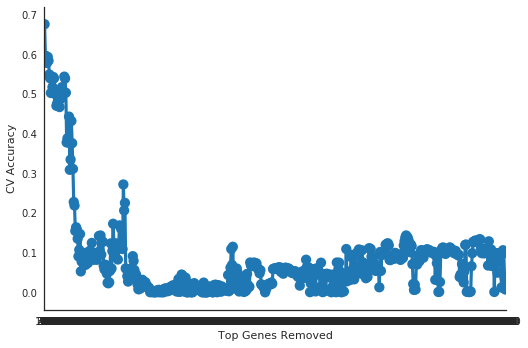

In [483]:
# Plot change in accuracy over iterations
sns.set_context('notebook')
plotr = pandas.DataFrame(index=range(len(cv_acc)), columns = ['Top Genes Removed','CV Accuracy'])
#plotr.loc[:,'Top Genes Removed'] = range(100,5100,100)
plotr.loc[:,'Top Genes Removed'] = range(100,58610,100)
plotr.loc[:,'CV Accuracy'] = cv_acc
plt.close()
sns.factorplot(x='Top Genes Removed', y = 'CV Accuracy', data=plotr, aspect=1.5, size=5)
plt.show()

Now repeat except remove 100 random probes instead of 100 top probes

In [10]:
null_cv_acc = []
fxp = pandas.DataFrame(xp, copy=True)
for i in range(585):
    print('round',i)
    jnk = PCA_LR_pipeline(fxp.values.T, 
                            (df.position_along_hipp_AP_axis), 
                            cv_strategy='score', illustrative=False,
                               sanity_check_style = 'model')
    null_cv_acc.append(jnk['CV_scores'])
    
    dropper = np.random.randint(0,len(fxp.index),100)
    fxp.drop(dropper, inplace=True)
    fxp.index = range(len(fxp.index))

In [11]:
# LOOKS LIKE I DIDN'T TAKE IT ALL THE WAY...
for i in range(585,589):
    print('round',i)
    jnk = PCA_LR_pipeline(fxp.values.T, 
                            (df.position_along_hipp_AP_axis), 
                            cv_strategy='score', illustrative=False,
                               sanity_check_style = 'model')
    null_cv_acc.append(jnk['CV_scores'])

    dropper = np.random.randint(0,len(fxp.index),100)
    fxp.drop(dropper, inplace=True)
    fxp.index = range(len(fxp.index))

In [ ]:
# PUT IT ALL TOGETHER
plotr = pandas.DataFrame(index=range(len(cv_acc)*2), 
                         columns = ['Genes Removed','CV Accuracy (r2)', 
                                    'Category'])
#plotr.loc[:,'Genes Removed'] = list(range(100,5100,100))*2
plotr.loc[:,'Genes Removed'] = list(range(100,59000,100))*2
plotr.loc[:,'CV Accuracy (r2)'] = cv_acc + null_cv_acc
#plotr.loc[:,'Category'] = ['Top Genes' if x <50 else 'Random Genes' for x in range(100)]
plotr.loc[:,'Category'] = ['Top Genes' if x <589 else 'Random Genes' for x in range(1178)]
sns.set_context('poster')


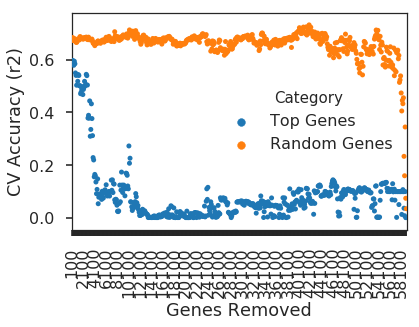

In [442]:
# PLOT IT
plt.close()
g = sns.stripplot(x='Genes Removed', y = 'CV Accuracy (r2)', hue = 'Category',
             data=plotr)
for ind, label in enumerate(g.get_xticklabels()):
    #if ind % 10 == 0:  # every 10th label is kept
    if ind % 20 == 0:  # every 20th label is kept
        label.set_visible(True)
        label.set_rotation(90)
    else:
        label.set_visible(False)
#plt.savefig(os.path.join(fig_dir,'CV_Acc_gene_removal_589.pdf'),
#           bbox_inches='tight')
plt.show()

In [25]:
### STOPPING POINTS OF EACH GENE SET
step1 = 100
step2 = 600
step3 = 2800

In [59]:
# SUMMARIZE INFORMATION OF TOP 5000 GENES...
mod_genes = pandas.DataFrame(index = range(5000),
                            columns = ['probe_ind','ant-post','step'])
mod_genes.loc[:,'probe_ind'] = imp_genes
mod_genes.loc[:,'gene_symbol'] = probes.loc[mod_genes['probe_ind'].values,'gene_symbol'].values
mod_genes.loc[:,'step'] = [1 if x <= step1 else 2 if x <= step2 else 3 if x <= step3 else 4 for x in range(5000)]
ant_ind,post_ind = [],[]
for i in range(50):
    post_ind += (np.arange(50) + (100*i)).tolist()
    ant_ind += (np.arange(50,100) + (100*i)).tolist()
mod_genes.loc[post_ind,'ant-post'] = 'posterior'
mod_genes.loc[ant_ind,'ant-post'] = 'anterior'
mod_genes.head()

probe_ind   ant-post  step   gene_symbol
0      12941  posterior     1           GAL
1      47792  posterior     1  A_24_P102119
2       8962  posterior     1       ONECUT2
3      26238  posterior     1        PDLIM5
4        343  posterior     1        COL5A2

In [15]:
mod_genes.to_csv(os.path.join(wdir,'MAIN_model_genes_of_importance.csv'))

In [36]:
mod_genes = pandas.read_csv(os.path.join(wdir, 'MAIN_model_genes_of_importance.csv'),
                           index_col=0)
mod_genes.index = mod_genes.probe_ind
mod_genes.head()

probe_ind   ant-post  step   gene_symbol
probe_ind                                          
12941          12941  posterior     1           GAL
47792          47792  posterior     1  A_24_P102119
8962            8962  posterior     1       ONECUT2
26238          26238  posterior     1        PDLIM5
343              343  posterior     1        COL5A2

# Comparing individual gene sets in predicting A-P axis

In [8]:
# Get a Probe x Sample matrix for each "gene set"
top_100 = xp.loc[mod_genes[mod_genes.step==1].index]
top_100_600 = xp.loc[mod_genes[mod_genes.step==2].index]
top_600 = xp.loc[mod_genes[mod_genes.step<3].index]
top_600_2700 = xp.loc[mod_genes[mod_genes.step==3].index]
top_2700 = xp.loc[mod_genes[mod_genes.step<4].index]
top_2700_5k = xp.loc[mod_genes[mod_genes.step==4].index]
t5k_ind = [x for x in xp.index if x not in mod_genes.probe_ind.values]
top_5k_end = xp.loc[t5k_ind]
all_subs = xp.loc[mod_genes.loc[mod_genes.index].index]


In [9]:
# ID non-overlapping gene sets
gene_sets = [top_100, top_100_600, 
             top_600_2700, top_2700_5k,
            top_5k_end, all_subs]

# Make empty dataframe
hla_scores = pandas.DataFrame(index = range(180), columns = ['score','model_type','sample'])
hla_scores.loc[:,'model_type'] = (['model']*10 + ['null']*10 + ['inner set (100)']*10) * 6
hla_scores.loc[:,'sample'] = ['Set1 (n=100)']*30 + ['Set2 (n=500)']*30 + \
                             ['Set3 (n=1100)']*30 + ['Set4 (n=2300)']*30 + \
                             ['Not in Sets1-4 (n=53k)']*30 + ['all (n=58k)']*30


For each non-overlapping gene-set, performing the following models:
* Perform 10 (bootstrapped) models using only probes in the gene set
* Perform 10 "null" models involving n-length sets of randomly selected probes where n equals the size of the gene set
* Perform 10 "inner-set" models involving 100 probes randomly selected from *within* the gene set.

This latter comparison is to compare to other sets to Set 1, which contains only 100 probes.

In [83]:
#### THIS ALSO TAKES QUITE A LONG TIME TO RUN

i = 0
for g,gset in enumerate(gene_sets):
    if g==0:
        hla_scores.loc[i:i+9,'score'] = hap.bootstrap_model(gset, xp, 
                                                            df.position_along_hipp_AP_axis, 
                                                            smallset=True)
        i += 10
        hla_scores.loc[i:i+9,'score'] = hap.bootstrap_model(gset, xp, 
                                                            df.position_along_hipp_AP_axis, 
                                                            bs_type='null', smallset=True)
        i += 10
        hla_scores.loc[i:i+9,'score'] = hap.bootstrap_model(gset, xp, 
                                                            df.position_along_hipp_AP_axis,
                                                            bs_type='inner_set', inner_set=100, 
                                                            smallset=True)
        i += 10
    else:
        hla_scores.loc[i:i+9,'score'] = hap.bootstrap_model(gset, xp, 
                                                            df.position_along_hipp_AP_axis)
        i += 10
        hla_scores.loc[i:i+9,'score'] = hap.bootstrap_model(gset, xp, 
                                                            df.position_along_hipp_AP_axis, 
                                                            bs_type='null')
        i += 10
        hla_scores.loc[i:i+9,'score'] = hap.bootstrap_model(gset, xp, 
                                                            df.position_along_hipp_AP_axis,
                                                            bs_type='inner_set', inner_set=100)
        i += 10

Plot it

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):
/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


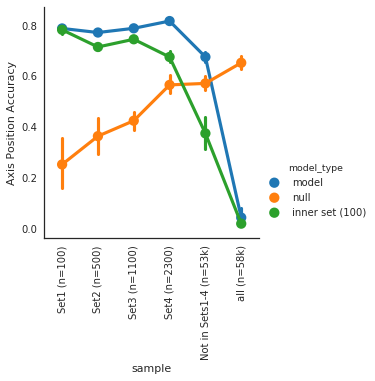

In [188]:
sns.set_context('notebook')
plt.close()
g = sns.factorplot(x='sample',y='score',hue='model_type',data=hla_scores)
g.set_xticklabels(g.ax.get_xticklabels(),rotation=90)
plt.ylabel('Axis Position Accuracy')
#plt.savefig(os.path.join(fig_dir,'model_comparison.pdf'), bbox_inches='tight')
plt.show()

In [27]:
# SAVE THE GENE SETS TO DISK AND SAVE THE PREDICTED VALUES TO SPREADSHEET FOR USE LATER
gsets = dict(zip(['top_100', 'top_100_600', 
             'top_600_2700', 'top_2700_5k',
            'top_5k_end']
                 ,gene_sets[:-1]))
gsets.update({'top_600': top_600})
gsets.update({'top_2700': top_2700})

for gset, xpdf in gsets.items():
    print('working on',gset)
    if gset != 'top_100':
        otpt = hap.PCA_LR_pipeline(xpdf.T, df.position_along_hipp_AP_axis, 
                               cv_strategy='score', illustrative=False, 
                                sanity_check_style ='model')
        pca_tfm = otpt['pca_object'].transform(xpdf.values.T) # transform with PCA
        predicted = otpt['final_model'].predict(pca_tfm) # get predicted values
    else:
        otpt = hap.PCA_LR_pipeline(xpdf.T, df.position_along_hipp_AP_axis, pca=None,
                            clf = linear_model.LassoCV(cv=10, max_iter=5000),
                            cv_strategy='score', illustrative=False,
                            sanity_check_style='model')
        predicted = otpt['final_model'].predict(xpdf.T) # get predicted values
    df.loc[:,gset] = predicted
    
    xpdf.to_csv(os.path.join(wdir,'GSET_%s_gxp.csv'%gset))

In [28]:
df.to_csv(os.path.join(wdir,'MAIN_hippocampus_sample_info_W_SMALL_SETS.csv'))

## Use LIME do to some Feature Explaining!

running trial 0
Intercept 99.65319556495767
Prediction_local [96.83491432]
Right: 96.511
Intercept 96.33462292556528
Prediction_local [106.42473899]
Right: 107.906
Intercept 96.15132439510296
Prediction_local [107.35939123]
Right: 108.493
Intercept 99.16802477702234
Prediction_local [97.97357395]
Right: 97.632
Intercept 98.00411072649919
Prediction_local [101.86849432]
Right: 100.436
Intercept 96.70655317674907
Prediction_local [105.76834806]
Right: 107.353
Intercept 95.74679242777144
Prediction_local [108.54136918]
Right: 109.116
Intercept 96.71529949784416
Prediction_local [105.78803513]
Right: 107.148
Intercept 98.91901268139029
Prediction_local [98.9191163]
Right: 99.146
Intercept 98.4727578673826
Prediction_local [99.96225763]
Right: 98.302
Intercept 100.64213722848733
Prediction_local [93.73896078]
Right: 93.18
Intercept 100.0165163218628
Prediction_local [95.68566053]
Right: 95.215
Intercept 100.41210413969235
Prediction_local [94.68388784]
Right: 92.945
Intercept 97.38119593923

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):
/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


14244 4.6 5
22547 26.6 27
23274 27.6 28
29383 43.6 44
40112 62.6 63
8892 96.6 97


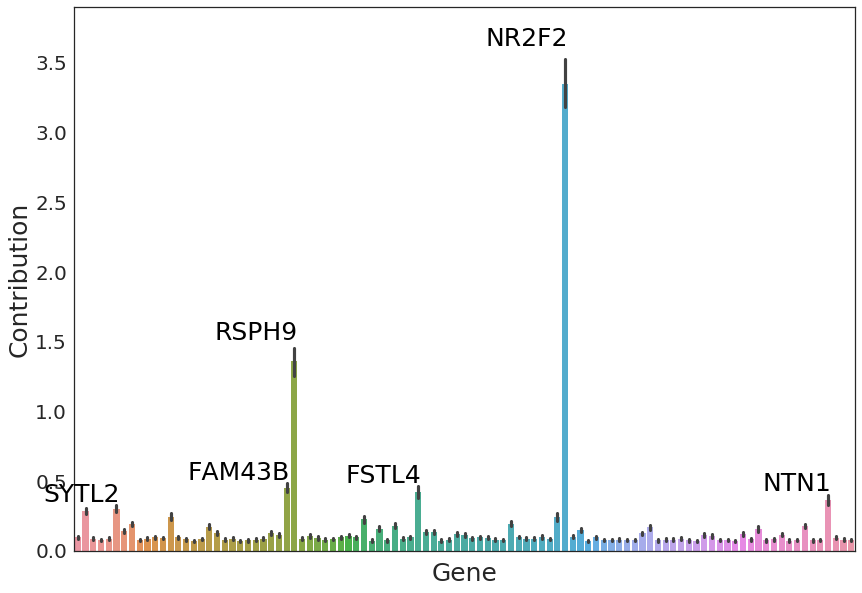

In [186]:
pltr = hap.feature_explainer_pipeline(top_100, 
                                      df.position_along_hipp_AP_axis, 
                                      probes)
# Scroll all the way down for plots

#### How does the model do without those top genes, compared to removing five random genes?
This did not make it into the manuscript...

In [767]:
# ID selected probes
impgenes = ['RSPH9','FAM43B','FSTL4','NTN1','NR2F2']
imp_ind = [x for x in top_100.index if probes.loc[x, 'gene_symbol'] in impgenes]

# Make empty dataframe for results
n_genes = len(imp_ind)
imp_rem_res = pandas.DataFrame(index = range(n_iter+1),
                               columns = ['model','r2'])
# Drop the selected probes
c=0
jnk = pandas.DataFrame(top_100, copy=True)
jnk.drop(imp_ind, inplace=True)
# Run model without those probes
newmod = PCA_LR_pipeline(jnk.values.T,
                        (df.position_along_hipp_AP_axis), pca=None,
                        clf = linear_model.LassoCV(cv=10,max_iter=5000),
                        cv_strategy='score', illustrative=False,
                        sanity_check_style = 'model')
# Store results
imp_rem_res.loc[c,'model'] = 'True'
imp_rem_res.loc[c, 'r2'] = newmod['CV_scores']
c+=1

# Now repeat n times but selecting 5 random genes for removal
n_iter = 100
for i in range(n_iter):
    dsamp = np.random.choice(top_100.index, size = n_genes, replace=False)
    jnk = pandas.DataFrame(top_100, copy=True)
    jnk.drop(dsamp, inplace=True)
    newmod = PCA_LR_pipeline(jnk.values.T,
                            (df.position_along_hipp_AP_axis), pca=None,
                            clf = linear_model.LassoCV(cv=10,max_iter=5000),
                            cv_strategy='score', illustrative=False,
                            sanity_check_style = 'model')
    imp_rem_res.loc[c,'model'] = 'Null'
    imp_rem_res.loc[c, 'r2'] = newmod['CV_scores']
    c+=1

performing model cross-validation
using basic 10-fold cross-validation
model cv score: r2 =  0.76331520989
running final model
final model fit r2 =  0.885619268452
running sanity_check
performing model cross-validation
using basic 10-fold cross-validation
model cv score: r2 =  0.780017955115
running final model
final model fit r2 =  0.899234112517
running sanity_check
performing model cross-validation
using basic 10-fold cross-validation
model cv score: r2 =  0.805508947325
running final model
final model fit r2 =  0.91273549057
running sanity_check
performing model cross-validation
using basic 10-fold cross-validation
model cv score: r2 =  0.81870606622
running final model
final model fit r2 =  0.909024093817
running sanity_check
performing model cross-validation
using basic 10-fold cross-validation
model cv score: r2 =  0.793694345071
running final model
final model fit r2 =  0.905355526741
running sanity_check
performing model cross-validation
using basic 10-fold cross-validation
mo

Visualize results

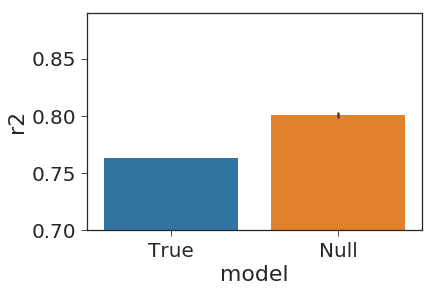

In [771]:
plt.close()
sns.barplot(x='model',y='r2',data=imp_rem_res,)
plt.ylim(0.7, 0.89)
plt.show()

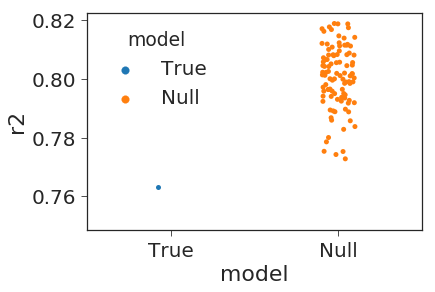

In [772]:
plt.close()
sns.stripplot(x='model',y='r2',hue='model',data=imp_rem_res, jitter=True)
#plt.ylim(0.7, 0.89)
plt.show()

## Find "bigrams" (similar features) to the "most important" features
This function will search all available probes that have collinear expression patterns to a target probe, and will return some information. This also didn't make it into the MS

           r2       r   name   rank
30409  0.3036  0.5510  SYTL2  58387
14246  0.5563  0.7459  SYTL2  58684
14245  0.5573  0.7465  SYTL2  58685
14244  0.5682  0.7538  SYTL2  58687
correlation greater than 0.999914809514% of other genes


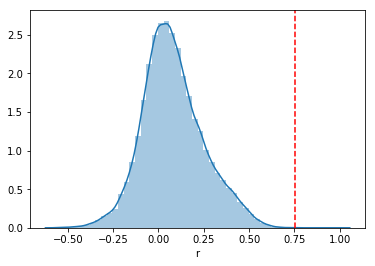

           r2       r     name   rank
17746  0.0155  0.1243  PLEKHO2  32627
17747  0.5237  0.7237  PLEKHO2  58681
correlation greater than 0.999812580931% of other genes


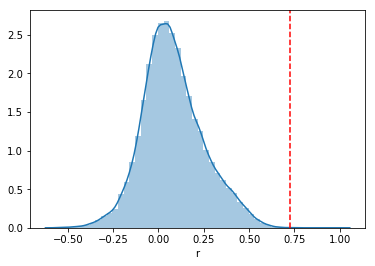

          r2       r  name   rank
3527  0.5016  0.7082  MT2A  58678
3525  0.5095  0.7138  MT2A  58679
3526  0.5196  0.7208  MT2A  58680
correlation greater than 0.999795542834% of other genes


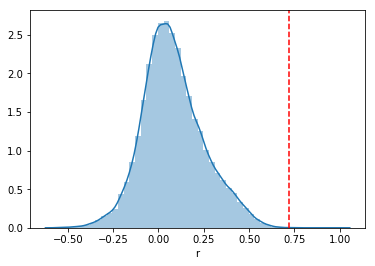

In [1010]:
# NR2F2
hap.find_bigram(xp, 40112, probes.gene_symbol, report = False, check_type = 'r2', check_val=0.5,
            check_genes = probes.loc[top_600_2700.index,'gene_symbol'].unique().tolist())

          r2       r   name   rank
23275  0.355  0.5958  RSPH9  58680
23274  1.000  1.0000  RSPH9  58691
correlation greater than 0.999982961903% of other genes


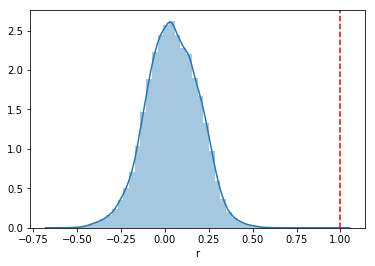

In [1049]:
# RSPH9
hap.find_bigram(xp, 23274, probes.gene_symbol, report = False, check_type = 'r2', check_val=0.5,
            check_genes = probes.loc[top_2700.index,'gene_symbol'].unique().tolist())

         r2       r    name   rank
343  0.1681  0.4100  COL5A2  51238
344  0.3834  0.6192  COL5A2  57732
345  0.5153  0.7179  COL5A2  58544
correlation greater than 0.997478361617% of other genes


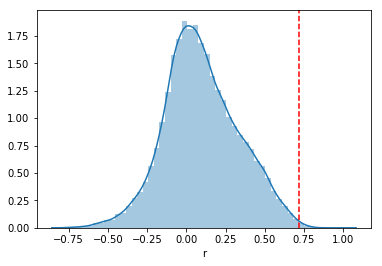

           r2       r    name   rank
22546  0.1694  0.4116  FAM43B  51303
22547  1.0000  1.0000  FAM43B  58691
correlation greater than 0.999982961903% of other genes


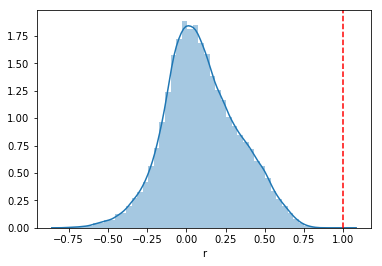

          r2       r   name   rank
5009  0.4314  0.6568  PVALB  58163
5008  0.5105  0.7145  PVALB  58531
correlation greater than 0.997256866353% of other genes


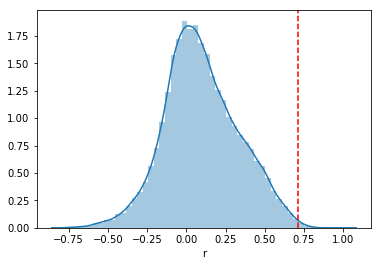

           r2       r          name   rank
27224  0.4696 -0.6853  RP11-45B20.3  58390
correlation greater than 0.99485449465% of other genes


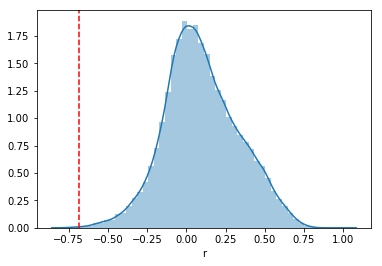

           r2       r  name   rank
27202  0.0167  0.1292  CD36  25753
37571  0.5303 -0.7282  CD36  58578
42596  0.5440 -0.7376  CD36  58607
correlation greater than 0.998551761739% of other genes


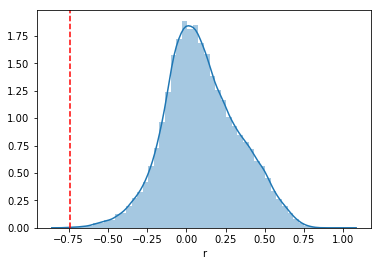

           r2       r name   rank
41256  0.1256 -0.3544  MYB  48143
3668   0.4235 -0.6508  MYB  58103
correlation greater than 0.989964560758% of other genes


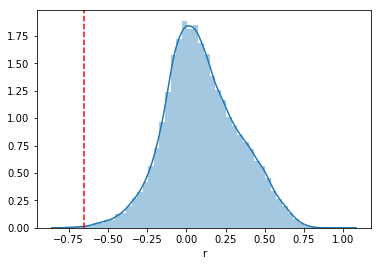

           r2       r   name   rank
10214  0.1819 -0.4264  GPR83  52050
10215  0.2238 -0.4731  GPR83  53987
10216  0.4431 -0.6656  GPR83  58252
correlation greater than 0.992503237238% of other genes


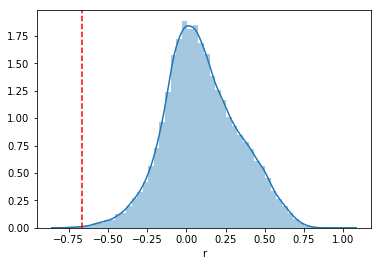

           r2       r   name   rank
24482  0.1829 -0.4277  RSPO2  52106
24484  0.3511 -0.5925  RSPO2  57326
24483  0.4377 -0.6616  RSPO2  58216
correlation greater than 0.99188986574% of other genes


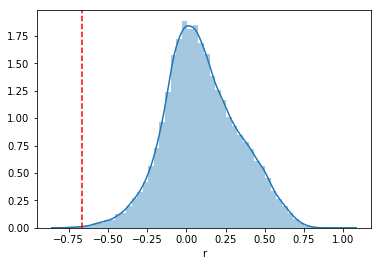

In [998]:
# FAM43B
hap.find_bigram(xp, 22547, probes.gene_symbol, report = False, check_type = 'r2', check_val=0.4,
            check_genes = probes.loc[top_100.index,'gene_symbol'].unique().tolist())

           r2       r   name   rank
29384  0.7905  0.8891  FSTL4  58690
29383  1.0000  1.0000  FSTL4  58691
correlation greater than 0.999982961903% of other genes


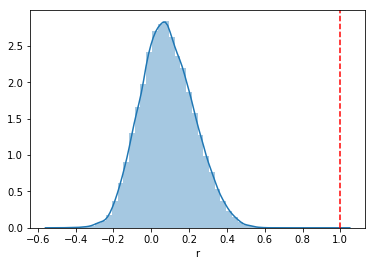

In [1002]:
# FSTL4
hap.find_bigram(xp, 29383, probes.gene_symbol, report = False, check_type = 'r2', check_val=0.4,
            check_genes = probes.loc[top_100.index,'gene_symbol'].unique().tolist())

#### Let's do some "Feature Explainers for other gene sets. Starting with Gene Set 2:

In [ ]:
pltr = hap.feature_explainer_pipeline(top_100_600, df.position_along_hipp_AP_axis, 
                                      probes, nm_thresh=0.2)

#### Gene set 1 + 2 Combined

In [ ]:
pltr = hap.feature_explainer_pipeline(top_600, df.position_along_hipp_AP_axis, 
                                      probes, nm_thresh=0.2)

#### Gene Set 3

In [ ]:
pltr = hap.feature_explainer_pipeline(top_600_2700, df.position_along_hipp_AP_axis, 
                                      probes, nm_thresh=0.2)

#### Gene set 1 + 2 + 3 Combined

In [ ]:
pltr = hap.feature_explainer_pipeline(top_2700, df.position_along_hipp_AP_axis, 
                                      probes, nm_thresh=0.2)

## Viewing expression patterns of top genes

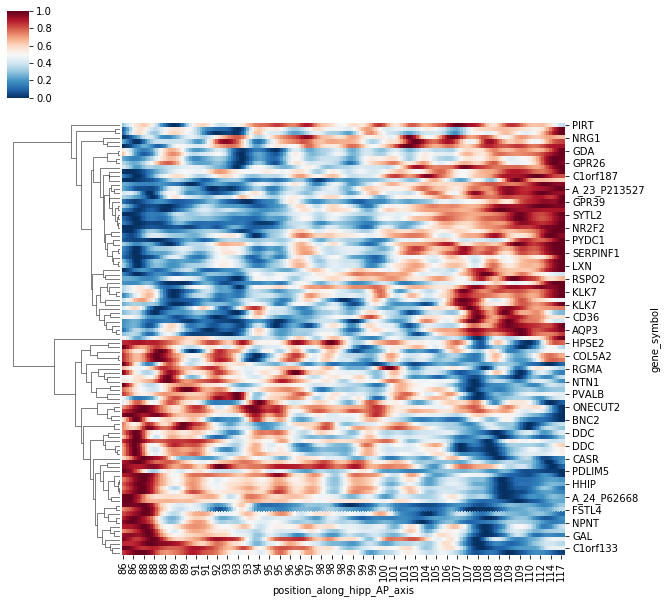

In [10]:
# Gene Set 1

# Identify gene set
jnk = xp.loc[mod_genes[mod_genes.step==1]['probe_ind'],
            xp.columns[df.sort_values('position_along_hipp_AP_axis').index]]

# Smooth the data along X (axis position) with a 3mm kernel for easier viewing/clustering
sjnk = pandas.DataFrame(ndimage.gaussian_filter1d(jnk,3,1), 
                        index = probes.loc[jnk.index,'gene_symbol'], 
                        columns = df.sort_values('position_along_hipp_AP_axis').position_along_hipp_AP_axis)
# Cluster and plot
plt.close()
g = sns.clustermap(#jnk,
                sjnk,
               col_cluster=False, metric='correlation', standard_scale=0,
               cmap='RdBu_r')
#g.fig.savefig(os.path.join(fig_dir,'top100_cluster.pdf'), bbox_inches='tight')
plt.show()

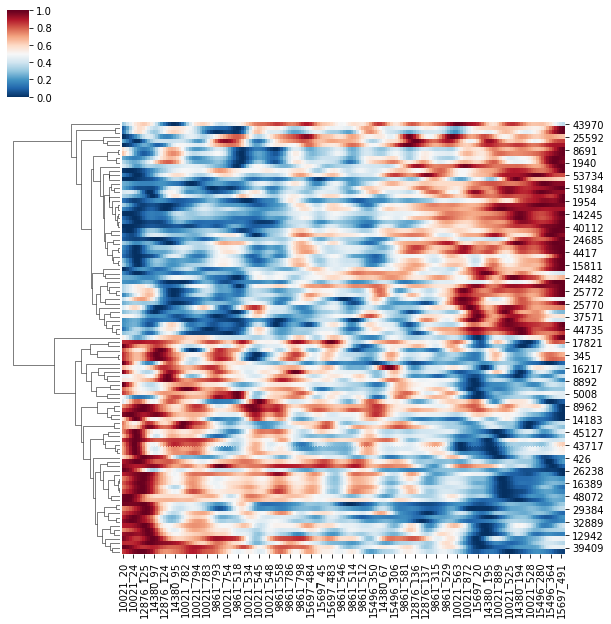

In [11]:
# Repeat for Gene Set 1 + 2

jnk = xp.loc[mod_genes[mod_genes.step<2]['probe_ind'],
            xp.columns[df.sort_values('position_along_hipp_AP_axis').index]]
sjnk = pandas.DataFrame(ndimage.gaussian_filter1d(jnk,3,1), index = jnk.index, columns = jnk.columns) 
plt.close()
g2 = sns.clustermap(sjnk,
               col_cluster=False, metric='correlation', standard_scale=0,
               cmap='RdBu_r')
plt.show()

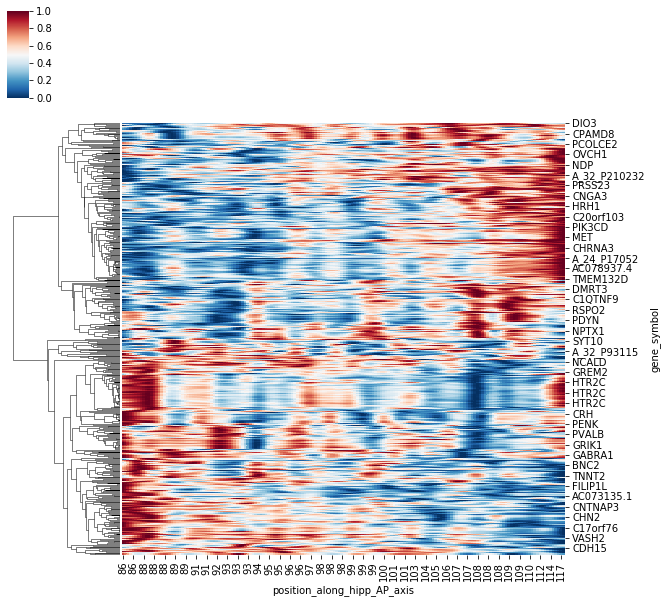

In [12]:
# Repeat for Gene Set 2 alone

jnk = xp.loc[mod_genes[mod_genes.step==2]['probe_ind'],
            xp.columns[df.sort_values('position_along_hipp_AP_axis').index]]
sjnk = pandas.DataFrame(ndimage.gaussian_filter1d(jnk,3,1), 
                       index = probes.loc[jnk.index,'gene_symbol'], 
                       columns = df.sort_values('position_along_hipp_AP_axis').position_along_hipp_AP_axis) 
plt.close()
g2a = sns.clustermap(sjnk,
               col_cluster=False, metric='correlation', standard_scale=0,
               cmap='RdBu_r')
plt.show()

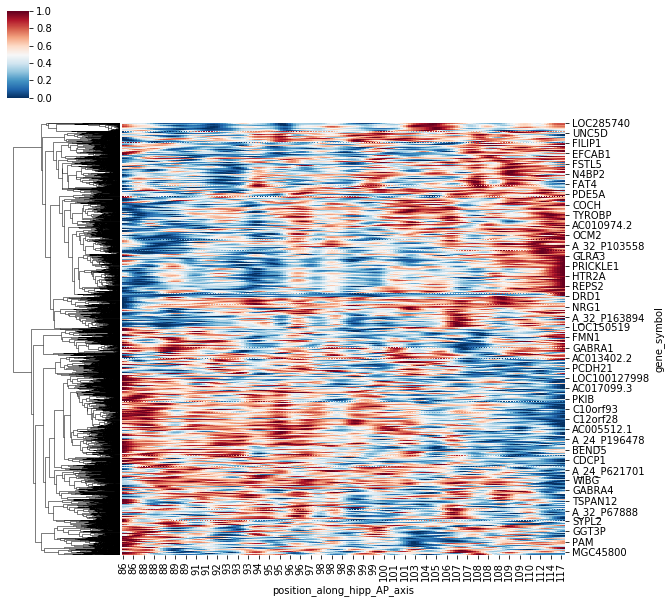

In [13]:
# Repeat for Gene Set 3 alone

jnk = xp.loc[mod_genes[mod_genes.step==3]['probe_ind'],
            xp.columns[df.sort_values('position_along_hipp_AP_axis').index]]
sjnk = pandas.DataFrame(ndimage.gaussian_filter1d(jnk,3,1),
                       index = probes.loc[jnk.index,'gene_symbol'], 
                       columns = df.sort_values('position_along_hipp_AP_axis').position_along_hipp_AP_axis) 
plt.close()
g3a = sns.clustermap(sjnk,
               col_cluster=False, metric='correlation', standard_scale=0,
               cmap='RdBu_r')
#g3a.fig.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/top6_2700_cluster.pdf')
plt.show()

## Making meaningful clusters out of gene/annotation relationships
For Gene Sets 2 and 3, there were many, many "hits" indicating enriched functions, processes and components. These analyses attempt to cluster the individual genes into clusters of shared enriched terms.

#### Gene Set 2

In [14]:
# Locate spreadsheets, which were generated using GOrilla

# Specifically, the specific genes produced in Set 2 and 3 above we're passed to GOrilla, and all genes
# available in the dataset were entered as background.

go_proc = os.path.join(wdir,'GOPROCESS.xls')
go_comp = os.path.join(wdir,'GOCOMPONENT.xls')
go_func = os.path.join(wdir,'GOFUNCTION.xls')
gos = [go_proc,go_comp,go_func]

In [15]:
# Consolidate into a dataframe
go_gsea = hap.prepare_GO_terms(top_100_600, gos, probes)
go_gsea.head()

anterograde trans-synaptic signaling  chemical synaptic transmission  \
PTX3                                     0.0                             0.0   
GABRA1                                   1.0                             1.0   
PDCD6                                    0.0                             0.0   
HTR2C                                    1.0                             1.0   
TAC1                                     1.0                             1.0   

        synaptic signaling  trans-synaptic signaling  nervous system process  \
PTX3                   0.0                       0.0                     0.0   
GABRA1                 1.0                       1.0                     1.0   
PDCD6                  0.0                       0.0                     0.0   
HTR2C                  1.0                       1.0                     0.0   
TAC1                   1.0                       1.0                     1.0   

        system process  behavior  signal transduction  cell communication  \
PTX3               0.0       0.0                  0.0                 0.0   
GABRA1             1.0       0.0                  1.0                 1.0   
PDCD6              0.0       0.0                  1.0                 0.0   
HTR2C              0.0       1.0                  1.0                 1.0   
TAC1               1.0       1.0                  1.0                 1.0   

        multicellular organismal process            ...              \
PTX3                                 0.0            ...               
GABRA1                               1.0            ...               
PDCD6                                0.0            ...               
HTR2C                                1.0            ...               
TAC1                                 1.0            ...               

        chemorepellent activity  ammonium ion binding  \
PTX3                        0.0                   0.0   
GABRA1                      0.0                   0.0   
PDCD6                       0.0                   0.0   
HTR2C                       0.0                   1.0   
TAC1                        0.0                   0.0   

        chloride channel activity  ligand-gated cation channel activity  \
PTX3                          0.0                                   0.0   
GABRA1                        1.0                                   0.0   
PDCD6                         0.0                                   0.0   
HTR2C                         0.0                                   0.0   
TAC1                          0.0                                   0.0   

        GABA-gated chloride ion channel activity  \
PTX3                                         0.0   
GABRA1                                       1.0   
PDCD6                                        0.0   
HTR2C                                        0.0   
TAC1                                         0.0   

        ion transmembrane transporter activity  hormone activity  \
PTX3                                       0.0               0.0   
GABRA1                                     1.0               0.0   
PDCD6                                      0.0               0.0   
HTR2C                                      0.0               0.0   
TAC1                                       0.0               0.0   

        excitatory extracellular ligand-gated ion channel activity  \
PTX3                                                  0.0            
GABRA1                                                0.0            
PDCD6                                                 0.0            
HTR2C                                                 0.0            
TAC1                                                  0.0            

        G-protein coupled peptide receptor activity  GTPase inhibitor activity  
PTX3                                            0.0                        0.0  
GABRA1                                          0.0      

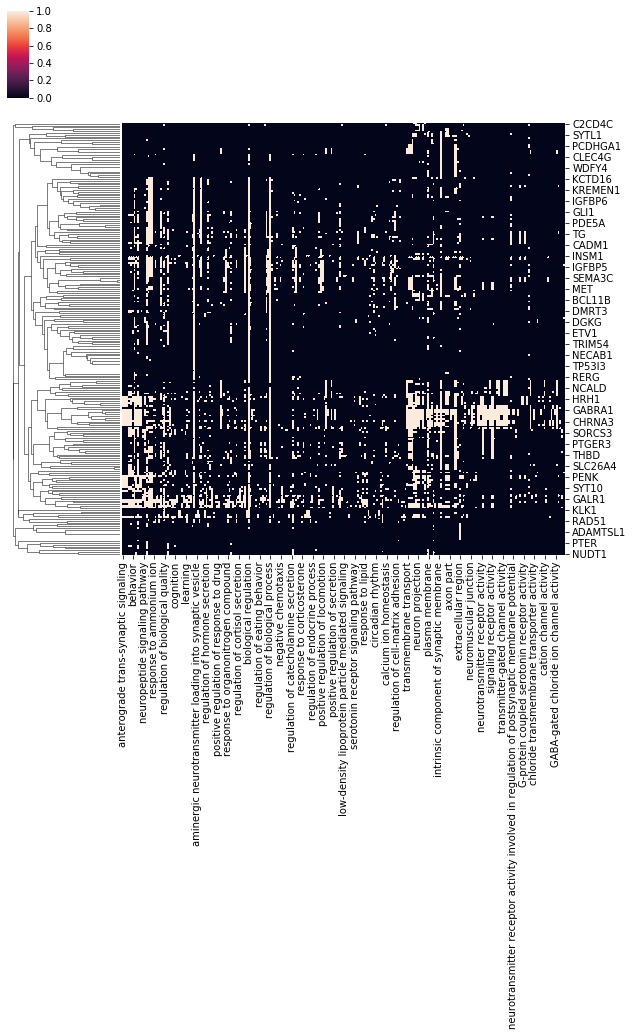

In [16]:
# Quick preview of what the clusters might look like

plt.close()
sns.clustermap(go_gsea, metric='jaccard', col_cluster=False)
plt.show()

In [793]:
# Cluster using 2-30-cluster solutions and compare based on silhouette scores and CH index 

# Create results dataframe
ks = range(2,31)
go_solutions2 = pandas.DataFrame(index = ks, columns = ['silhouette', 'CH_index',
                                                             'mean_size','min_size','max_size'])
X = go_gsea.values.T
for k in ks:
    # Perform cluster analysis
    connectivity = kneighbors_graph(X, n_neighbors=10, mode='distance', 
                                    metric = 'jaccard', include_self=False)
    clusterer = AgglomerativeClustering(n_clusters=k, connectivity=connectivity)
    cluster_labels = clusterer.fit_predict(X)
    # silhouette
    go_solutions2.loc[k,'silhouette'] = silhouette_score(X, cluster_labels)
    # CH Index
    go_solutions2.loc[k,'CH_index'] = calinski_harabaz_score(X, cluster_labels)
    # Get information on cluster size
    mtx2 = pandas.DataFrame(go_gsea.T.values, copy=True)
    mtx2.loc[:,'label'] = cluster_labels
    sizes = []
    for i in np.unique(mtx2.label):
        clus_data = mtx2[mtx2.label==i][mtx2.columns[:-1]]
        sizes.append(len(clus_data))
    # SIZES
    go_solutions2.loc[k,'mean_size'] = np.mean(sizes)
    go_solutions2.loc[k,'min_size'] = np.min(sizes)
    go_solutions2.loc[k,'max_size'] = np.max(sizes)
    print('finished',k)
go_solutions2.loc[:,'k'] = go_solutions2.index

finished 2
finished 3
finished 4
finished 5
finished 6
finished 7
finished 8
finished 9
finished 10
finished 11
finished 12
finished 13
finished 14
finished 15
finished 16
finished 17
finished 18
finished 19
finished 20
finished 21
finished 22
finished 23
finished 24
finished 25
finished 26
finished 27
finished 28
finished 29
finished 30


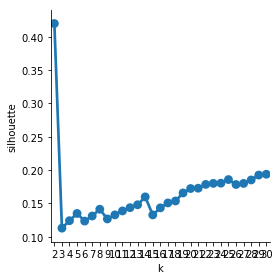

In [794]:
plt.close()
sns.factorplot(x='k',y='silhouette',data=go_solutions2)
plt.show()

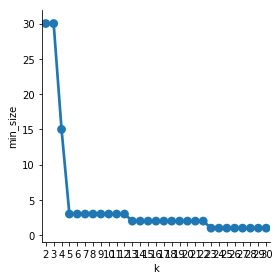

In [796]:
plt.close()
sns.factorplot(x='k',y='min_size',data=go_solutions2)
plt.show()

cluster 0
n =  58


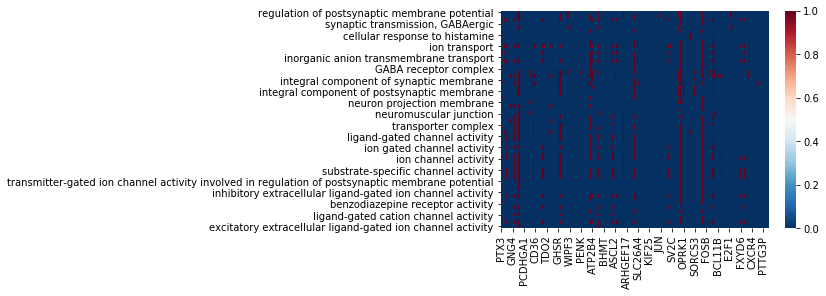

GRIA3      0.707317
FXYD6      0.692308
TRPM3      0.619048
NCALD      0.619048
KCNN3      0.590909
KCNK12     0.590909
GABRA2     0.573171
GABRA4     0.569767
GABRA1     0.560440
GABRD      0.539683
CHRNA1     0.520548
GABRQ      0.515625
KCNH5      0.500000
GABRB2     0.481481
GRIK1      0.462963
SLC2A12    0.461538
SLC39A2    0.461538
SLC26A4    0.444444
CNGA3      0.439024
HTR3A      0.386667
dtype: float64
['regulation of postsynaptic membrane potential', 'regulation of membrane potential', 'ion transmembrane transport', 'synaptic transmission, GABAergic', 'excitatory postsynaptic potential', 'chloride transmembrane transport', 'cellular response to histamine', 'response to histamine', 'chloride transport', 'ion transport', 'gamma-aminobutyric acid signaling pathway', 'inorganic ion transmembrane transport', 'inorganic anion transmembrane transport', 'transmembrane transport', 'GABA-A receptor complex', 'GABA receptor complex', 'synapse', 'plasma membrane region', 'integral compon

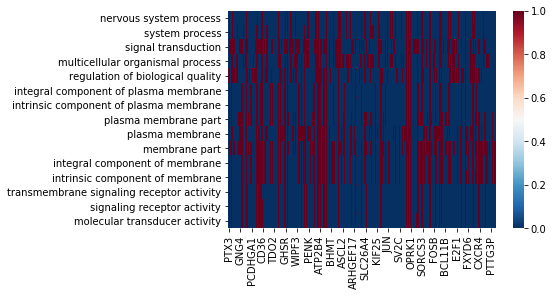

TMEM74B    1.000000
DCBLD1     1.000000
WDFY4      1.000000
CLDN20     1.000000
PCDHGA1    0.857143
PCDHB8     0.857143
MALL       0.833333
MARCH1     0.800000
DCHS2      0.800000
CNTNAP3    0.800000
TRHR       0.733333
SGCG       0.700000
MEGF11     0.666667
FRMPD2     0.666667
NTSR2      0.600000
IFNLR1     0.600000
GPR88      0.600000
SCARA5     0.538462
SLC2A12    0.538462
SLC39A2    0.538462
dtype: float64
['nervous system process', 'system process', 'signal transduction', 'multicellular organismal process', 'regulation of biological quality', 'integral component of plasma membrane', 'intrinsic component of plasma membrane', 'plasma membrane part', 'plasma membrane', 'membrane part', 'integral component of membrane', 'intrinsic component of membrane', 'transmembrane signaling receptor activity', 'signaling receptor activity', 'molecular transducer activity']
cluster 2
n =  33


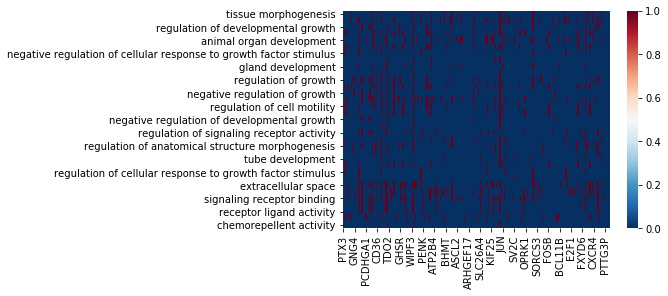

CPXM2       1.000000
ARSJ        1.000000
ADAMTSL1    1.000000
OVCH1       1.000000
ADAMTS19    1.000000
C1QL2       1.000000
COL21A1     0.800000
SEMA3D      0.552632
SEMA3C      0.543478
AIRE        0.538462
SEMA6D      0.538462
ONECUT2     0.500000
GREM2       0.500000
EFHD2       0.500000
GREB1L      0.454545
WNT4        0.434783
CCBE1       0.428571
WNT10A      0.428571
SLIT2       0.423077
ELN         0.400000
dtype: float64
['tissue morphogenesis', 'anatomical structure morphogenesis', 'regulation of developmental growth', 'regulation of locomotion', 'animal organ development', 'regulation of cell migration', 'negative regulation of cellular response to growth factor stimulus', 'semaphorin-plexin signaling pathway', 'gland development', 'negative chemotaxis', 'regulation of growth', 'regulation of cellular component movement', 'negative regulation of growth', 'negative regulation of multicellular organismal process', 'regulation of cell motility', 'positive regulation of locomot

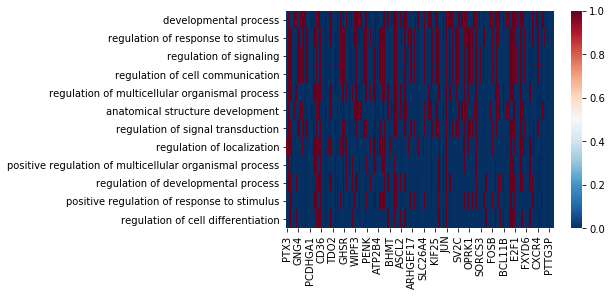

PTER       1.000000
CA10       0.666667
SPATA19    0.666667
TESPA1     0.642857
FAM150B    0.642857
RGS22      0.571429
CHN2       0.555556
KLK5       0.538462
PDE5A      0.529412
ASCL2      0.500000
RBPMS2     0.500000
E2F1       0.500000
STK3       0.476190
IFI16      0.461538
DACT2      0.461538
GLI1       0.458333
SEC14L1    0.454545
ARHGAP6    0.454545
HES5       0.454545
VASH2      0.454545
dtype: float64
['developmental process', 'regulation of response to stimulus', 'regulation of signaling', 'regulation of cell communication', 'regulation of multicellular organismal process', 'anatomical structure development', 'regulation of signal transduction', 'regulation of localization', 'positive regulation of multicellular organismal process', 'regulation of developmental process', 'positive regulation of response to stimulus', 'regulation of cell differentiation']
cluster 4
n =  3


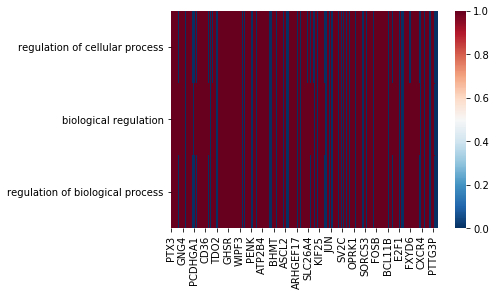

TP53I3      1.00
NABP1       1.00
PTTG3P      1.00
KIF25       1.00
HR          1.00
TOX3        1.00
NECAB1      0.75
FEV         0.75
IRX2        0.75
TBC1D16     0.75
ONECUT3     0.75
DIRAS2      0.60
PCOLCE2     0.60
RASL10A     0.60
ATOH7       0.50
DAPL1       0.50
TMEM132D    0.50
KLK1        0.50
BAIAP2L2    0.50
RARRES1     0.50
dtype: float64
['regulation of cellular process', 'biological regulation', 'regulation of biological process']
cluster 5
n =  14


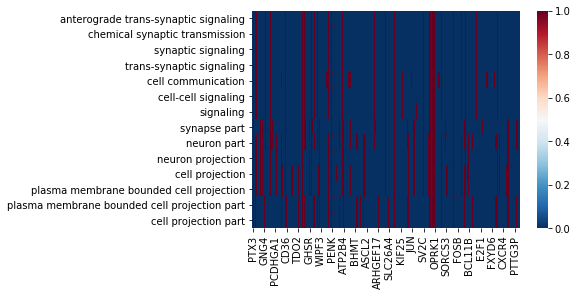

RSPH9     1.000000
DNAH12    1.000000
MLPH      0.857143
C2CD4C    0.666667
SV2C      0.631579
OSBPL3    0.500000
PDYN      0.400000
NPTX1     0.392857
PVALB     0.363636
SYTL1     0.363636
HTR7      0.342105
CCDC68    0.333333
UNC13C    0.333333
CHRM5     0.333333
LAYN      0.333333
NEXN      0.307692
LAMP5     0.307692
C1QL1     0.294118
TENM2     0.291667
SYT10     0.272727
dtype: float64
['anterograde trans-synaptic signaling', 'chemical synaptic transmission', 'synaptic signaling', 'trans-synaptic signaling', 'cell communication', 'cell-cell signaling', 'signaling', 'synapse part', 'neuron part', 'neuron projection', 'cell projection', 'plasma membrane bounded cell projection', 'plasma membrane bounded cell projection part', 'cell projection part']
cluster 6
n =  109


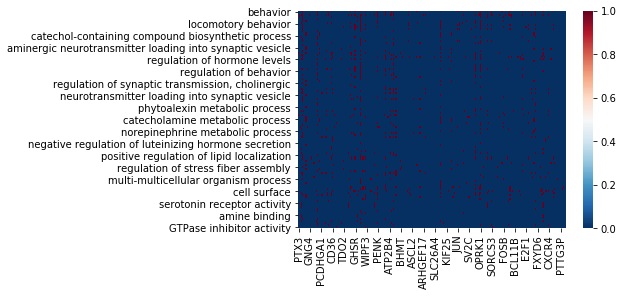

HDC       0.818182
MOXD1     0.647059
GALR1     0.568627
NMU       0.555556
DDC       0.555556
CRH       0.516129
TH        0.513889
TDO2      0.500000
GAL       0.472222
TAC1      0.471264
GALR2     0.461538
BHMT      0.428571
OPRK1     0.413043
FOSB      0.400000
BAIAP3    0.400000
DGKI      0.400000
INSM1     0.375000
DGKH      0.375000
GRP       0.370370
PVALB     0.363636
dtype: float64
['behavior', 'neuropeptide signaling pathway', 'G-protein coupled receptor signaling pathway', 'response to ammonium ion', 'positive regulation of glucocorticoid secretion', 'response to alkaloid', 'locomotory behavior', 'learning or memory', 'response to xenobiotic stimulus', 'cognition', 'positive regulation of corticosteroid hormone secretion', 'catecholamine biosynthetic process', 'catechol-containing compound biosynthetic process', 'feeding behavior', 'positive regulation of steroid hormone secretion', 'learning', 'regulation of response to drug', 'regulation of glucocorticoid secretion', 'ami

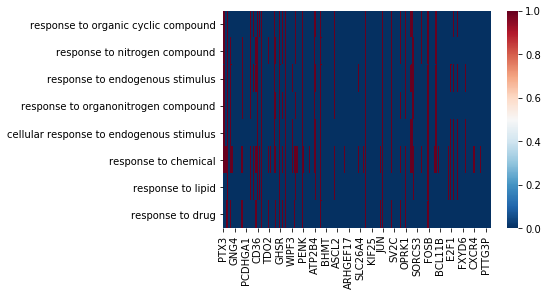

TDO2       0.500000
RAD51      0.466667
FOSB       0.400000
ENO3       0.333333
CPNE8      0.333333
SMAD9      0.307692
LRCOL1     0.250000
PTGES      0.250000
RFTN1      0.230769
RERG       0.222222
E2F1       0.200000
PCOLCE2    0.200000
GPR83      0.190476
NPAS4      0.185185
JUN        0.177778
STC2       0.176471
DDC        0.166667
THBD       0.166667
IGFBP5     0.162162
PTGFR      0.156250
dtype: float64
['response to organic cyclic compound', 'response to nitrogen compound', 'response to endogenous stimulus', 'response to organonitrogen compound', 'cellular response to endogenous stimulus', 'response to chemical', 'response to lipid', 'response to drug']


In [17]:
# Run clustering based on using a solution of K=8

subfields = df.structure_acronym.unique()
k = 8 

# Perform clustering and extract labels
X = go_gsea.values.T
connectivity = kneighbors_graph(X, n_neighbors=10, mode='distance', 
                                    metric = 'jaccard', include_self=False)
clusterer = AgglomerativeClustering(n_clusters=k, connectivity=connectivity)
cluster_labels = clusterer.fit_predict(X)
mtx2 = pandas.DataFrame(go_gsea.T, copy=True)
mtx2.loc[:,'label'] = cluster_labels

# For each cluster
for i in np.unique(mtx2.label):
    print('cluster',i)
    # Extract data from the cluster
    clus_data = mtx2[mtx2.label==i][mtx2.columns[:-1]]
    print('n = ',len(clus_data))
    # Plot it
    plt.close()
    sns.heatmap(pandas.DataFrame(clus_data),
               cmap = 'RdBu_r')
    plt.show()
    
    # Identify the most frequently enriched terms in the cluster
    # and the percentage of genes in the cluster that show enrichment
    # for each term
    top_hits = (clus_data.sum()/go_gsea.T.sum()).sort_values(ascending=False).head(20)
    print(top_hits)
    # Print the most enriched genes
    print(clus_data.index.tolist())
    
#     # A bunch of extra exploratory stuff
#     plt.close()
#     # Identify which genes are posteriorly expressed vs. anteriorly expressed
#     # Good god this next line is hideous. I'm so sorry.
#     xp_mtx = g2.data2d.loc[[x for x in g2.data2d.index if x in probes[probes.gene_symbol.isin(top_hits.index)
#                                                                      ].index]].reindex(columns=xp.columns)
#     rs = [stats.pearsonr(xp_mtx.loc[i],df.position_along_hipp_AP_axis.values)[0] for i in xp_mtx.index]
#     ap = np.array(['a' if x > 0 else 'p' for x in rs])
#     amtx = xp_mtx.loc[xp_mtx.index[ap=='a']]
#     pmtx = xp_mtx.loc[xp_mtx.index[ap=='p']]
#     # Print the number of anterior vs posterior genes
#     print('%s anterior, %s posterior'%(len(amtx),len(pmtx)))
#     # And which they are
#     print('anterior:', probes.loc[amtx.index,'gene_symbol'].unique())
#     print('posterior:', probes.loc[pmtx.index,'gene_symbol'].unique())
#     phdf = pandas.DataFrame(df,copy=True)
#     phdf.loc[:,'a_gxp'] = amtx.mean().values
#     phdf.loc[:,'p_gxp'] = pmtx.mean().values
#     # Store the cluster's association with axis position
#     ar = stats.pearsonr(phdf.a_gxp,phdf.position_along_hipp_AP_axis)[0]**2
#     pr = stats.pearsonr(phdf.p_gxp,phdf.position_along_hipp_AP_axis)[0]**2
#     print('anterior r2 = %s, posterior r2 = %s'%(ar,pr))
#     # And separately for each subfield
#     for subfield in subfields:
#         ars = stats.pearsonr(phdf[phdf.structure_acronym==subfield]['a_gxp'],
#                              df[df.structure_acronym==subfield].position_along_hipp_AP_axis)[0]**2
#         prs = stats.pearsonr(phdf[phdf.structure_acronym==subfield]['p_gxp'],
#                              df[df.structure_acronym==subfield].position_along_hipp_AP_axis)[0]**2
#         print('%s anterior = %s, posterior = %s'%(subfield,ars,prs))

#     # Plot the raw expression patterns of the anterior and posterior genes in the cluster
#     sns.heatmap(amtx,cmap='RdBu_r')
#     plt.show()
#     plt.close()
#     sns.heatmap(pmtx,cmap='RdBu_r')
#     plt.show()
#     #for x in clus_data.index:
#     #    print(x)
#     print('\n\n')

#### Pause for a revision: Which go clusters explain regional disease vulnerability?
This is jumping ahead to NB4, but it's easier to place the code here. For this to make sense, you may have to run NB4 and come back here (but the code after this section can be run without running this section). Unlike rsfmri connectivity and structural covariance to the hippocampus, disease vulnerability was not associated with HAGGIS composed of only Set1 features (i.e. the top 100 features of our model). We decided to look to see if specific GO clusters in Sets 2 and 3 (which were associated disease vulnerability) could explain the relationship between HAGGIS and disease, so we can compare them to the GO terms enrisched in Set1

In [18]:
shtz = sorted(glob(os.path.join(aba_dir,'normalized_microarray_donor*/MExp_all_genes_ctr_for_donor')))
holder = []
for sht in shtz:
    holder.append(pandas.read_csv(sht,index_col=0))
bigdf = pandas.concat(holder,axis=1)
del(holder)
ncols = ['%s_%s'%(gdf.loc[x,'donor'],bigdf.columns[x]) for x in range(gdf.shape[0])]
bigdf.columns = ncols

This runs a bunch of code that is explained much more slowly in NB4. It's copied exactly from NB4. Here we're running it all at once to get the desired outputs, namely sample-wise values for HAGGIS and disease expression

dis (121, 145, 121)
new shape (91, 109, 91)
dkt (182, 218, 182)
new shape (91, 109, 91)
HO (182, 218, 182)
new shape (91, 109, 91)


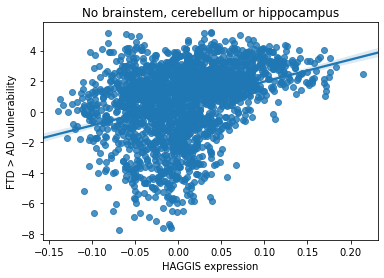

standard statistics: r2 = 0.11250092289014405, p = 5.173742000727973e-52


In [19]:
import nibabel as ni
from nilearn import image

# CHANGE THIS TO YOUR FDG DIR
fdg_dir = '/home/users/jvogel/Science/Allen_Human_Brain_Atlas/AD-FTD FDG Difference Map/'

# gather all the images
mni2mm = ni.load(os.path.join(wdir,'MNI152_T1_2mm_brain.nii.gz'))
d_diff = ni.load(os.path.join(fdg_dir,'AD-FTD_globalnorm2.nii.gz'))
HO = ni.load(os.path.join(wdir,'HarvardOxford-sub-maxprob-thr25-1mm.nii.gz'))
dkt = ni.load(os.path.join(wdir,'dkt_atlas_1mm.nii.gz'))
diffs = {'dis': d_diff, 'dkt': dkt, 'HO': HO}

# bring them to a common spac
diffs_2mm = {}
for lab,diff in diffs.items():
    print(lab,diff.shape)
    if lab == 'HO' or lab == 'dkt':
        nimg = image.resample_to_img(diff, mni2mm, interpolation='nearest')
    else:
        nimg = image.resample_to_img(diff, mni2mm)
    print('new shape', nimg.shape)
    diffs_2mm.update({lab: nimg})

# make the brainmasks

dkt2 = diffs_2mm['dkt'].get_data()
HO2mm = diffs_2mm['HO'].get_data()
msk1 = np.array(HO2mm,copy=True)
msk1[HO2mm<1] = 0
#no cereb or brainstem
msk2 = np.array(dkt2, copy=True)
msk2[msk2>78] = 0
msk2 = np.array(dkt2, copy=True)
msk2[msk2>78] = 0

# no cereb, brainstem or hippocampus
msk3 = np.array(msk2, copy=True)
msk3[dkt2==36] = 0
msk3[dkt2==75] = 0

# get association with disease vulnerability
# for samples within mask

img = diffs_2mm['dis'].get_data()
vrad=3
vdim = 2
gcx_col='AP_axis_gxp_signature_similarity_SPCR'
bootstrap = False
plabs = ['No brainstem, cerebellum or hippocampus',
         'HAGGIS expression','FTD > AD vulnerability']
res, vex = hap.run_gvfcx_analysis(img, gdf, msk3, vrad, vdim, gcx_col, plabs, 
                       bootstrap, n_iter=10, hue_vals=[], illustrative=True,
                                 joint_input='')

mcoords_idx = []
for i,row in gdf.iterrows():
    coord = hap.convert_coords([row['mni_nlin_x'], row['mni_nlin_y'], row['mni_nlin_z']], 
                           'xyz', vdim)
    coord = [round(x) for x in coord]
    #if msk[coord[0],coord[1],coord[2]] != 0:
    if msk3[coord[0],coord[1],coord[2]] > 0:
        mcoords_idx.append(i)

For each of the 8 clusters above, we will assign a "cluster centrality" weight to each gene in Set2, where the weight is determined by the percentage of cluster-specific enriched terms that gene is associated with. In this way, most genes will have a weight of 0. We then create a weighted mean of expression of all genes in Set2, weighted by cluster centrality. This creates a "cluster score", which we store.

We also repeat this process 100 times but this time randomly shuffling the cluster centrality weights to create a null model.  For each null model, we find the correlation between sample cluster score and sample disease vulnerability score, creating a null distribution to test against for the analysis below.

In [20]:
## WARNING: This take awhile to run

## Create empty dataframe to store null associations
n_iter = 100
nulls = np.zeros((len(mtx2.label.unique())*2,n_iter))

## Iterate through each cluster
for i in np.unique(mtx2.label):
    print('cluster',i)
    # Get cluster centrality
    weighter = pandas.DataFrame(columns = ['weight','AP'])
    clus_data = mtx2[mtx2.label==i][mtx2.columns[:-1]]
    top_hits = (clus_data.sum()/go_gsea.T.sum()).sort_values(ascending=False)
    for g in top_hits.index:
        inds = probes[probes.gene_symbol==g].index
        for ind in inds:
            if ind in mod_genes.index:
                weighter.loc[ind,'weight'] = top_hits[g]
                weighter.loc[ind,'AP'] = mod_genes.loc[ind,'ant-post']
    # separate into anterior and posterior genes
    for ap in ['anterior','posterior']:
        row_idx = i*2
        if ap == 'posterior':
            row_idx += 1
        # find weighted mean (aka cluster score)
        wdf = weighter[weighter.AP==ap]
        X = bigdf.loc[wdf.index].T
        cluster_score = (X * wdf.weight.values).mean(1).values
        gdf.loc[:,'Set2_C%s_%s'%(i,ap)] = cluster_score # save it
        # iterate through this process n_iter times, shuffle weights, find association, repeat
        for p in range(n_iter):
            np.random.shuffle(wdf.weight.values)
            cluster_score = (X * wdf.weight.values).mean(1).values
            r2 = stats.pearsonr(cluster_score[mcoords_idx], 
                                np.array(vex['cx_vector']))[0]**2
            nulls[row_idx,p] = r2

cluster 0
cluster 1
cluster 2
cluster 3
cluster 4
cluster 5
cluster 6
cluster 7


In [67]:
# Add titles for clusters
cr2.sort_values(['direction','cluster'],inplace=True)
cr2.loc[:,'Title'] = ['C0: Amine Processing',
                      'C1: Axon Guidance',
                      'C2: GABA Activity',
                      'C3: Hormonal Signaling',
                      'C4: Neuropeptide Activity',
                      'C5: Ion Transport',
                      'C6: LH Secretion',
                      'C7: Growth Factor Signaling'] * 2

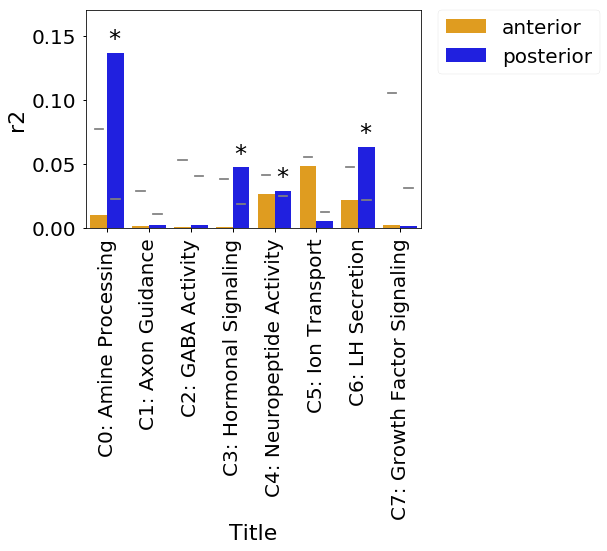

In [72]:
## Plot r2 between each cluster score and disease vulenerability,
## separately for anterior and posterior genes. Also plot gray bars
## representing the upper 95% confidence interval of the null model.
sns.set_context('notebook',font_scale=2)
plt.close()
g = sns.barplot(x='Title',y='r2',hue='direction',data=cr2,palette=['orange','blue'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
for i in cr2.index:
    row_idx = ((i+0.0001) / 2)
    if i%2==0:
        row_idx -= 0.2
    else:
        row_idx -= 0.3
    plt.plot([row_idx-0.1,row_idx+0.1],[cr2.loc[i,'null'],cr2.loc[i,'null']],'gray')
    if cr2.loc[i,'null'] < cr2.loc[i,'r2']:
        plt.text(row_idx-0.17, cr2.loc[i,'r2'] + 0.005, '*')
plt.ylim(0,0.17)
g.set_xticklabels(g.get_xticklabels(),rotation=90)
#plt.savefig(os.path.join(fig_dir,'Disease_CR2.pdf'),
#           bbox_inches='tight')
plt.show()


### Looks great! Repeat with all of that with Set 3!

In [22]:
go_proc = os.path.join(wdir,'GOPROCESS_6_2700.xlsx')
go_comp = os.path.join(wdir,'GOCOMPONENT_6_2700.xlsx')
go_func = os.path.join(wdir,'GOFUNCTION_6_2700.xlsx')
gos = [go_proc,go_comp,go_func]


In [23]:
go_gsea = hap.prepare_GO_terms(top_600_2700, gos, probes)
go_gsea.head()

anterograde trans-synaptic signaling  chemical synaptic transmission  \
GABRA1                                    1.0                             1.0   
COL25A1                                   0.0                             0.0   
CPNE8                                     0.0                             0.0   
CARTPT                                    1.0                             1.0   
HTR2C                                     1.0                             1.0   

         synaptic signaling  trans-synaptic signaling  system process  \
GABRA1                  1.0                       1.0             1.0   
COL25A1                 0.0                       0.0             0.0   
CPNE8                   0.0                       0.0             0.0   
CARTPT                  1.0                       1.0             0.0   
HTR2C                   1.0                       1.0             0.0   

         cell-cell signaling  ion transport  signaling  cell communication  \
GABRA1                   1.0            1.0        1.0                 1.0   
COL25A1                  0.0            0.0        0.0                 0.0   
CPNE8                    0.0            0.0        0.0                 0.0   
CARTPT                   1.0            0.0        1.0                 1.0   
HTR2C                    1.0            1.0        1.0                 1.0   

         ion transmembrane transport  \
GABRA1                           1.0   
COL25A1                          0.0   
CPNE8                            0.0   
CARTPT                           0.0   
HTR2C                            1.0   

                                      ...                                \
GABRA1                                ...                                 
COL25A1                               ...                                 
CPNE8                                 ...                                 
CARTPT                                ...                                 
HTR2C                                 ...                                 

         carboxylic acid transmembrane transporter activity  \
GABRA1                                                 0.0    
COL25A1                                                0.0    
CPNE8                                                  0.0    
CARTPT                                                 0.0    
HTR2C                                                  0.0    

         monovalent inorganic cation transmembrane transporter activity  \
GABRA1                                                 0.0                
COL25A1                                                0.0                
CPNE8                                                  0.0                
CARTPT                                                 0.0                
HTR2C                                                  0.0                

         cGMP binding  chloride transmembrane transporter activity  \
GABRA1            0.0                                          1.0   
COL25A1           0.0                                          0.0   
CPNE8             0.0                                          0.0   
CARTPT            0.0                                          0.0   
HTR2C             0.0                                          0.0   

         transmembrane receptor protein tyrosine kinase activity  \
GABRA1                                                 0.0         
COL25A1                                                0.0         
CPNE8                                                  0.0         
CARTPT                                                 0.0         
HTR2C                                                  0.0         

         organic anion transmembrane transporter activity  \
GABRA1                                                0.0   
COL25A1                                               0.0   
CPNE8                                                 0.0   
CARTPT            

In [632]:
ks = range(2,50)
go_solutions = pandas.DataFrame(index = ks, columns = ['silhouette', 'CH_index',
                                                             'mean_size','min_size','max_size'])
X = go_gsea.values
for k in ks:
    connectivity = kneighbors_graph(X, n_neighbors=100, mode='distance', 
                                    metric = 'jaccard', include_self=False)
    clusterer = AgglomerativeClustering(n_clusters=k, connectivity=connectivity)
    cluster_labels = clusterer.fit_predict(X)
    # silhouette
    go_solutions.loc[k,'silhouette'] = silhouette_score(X, cluster_labels)
    # CH Index
    go_solutions.loc[k,'CH_index'] = calinski_harabaz_score(X, cluster_labels)
    mtx = pandas.DataFrame(go_gsea.values, copy=True)
    mtx.loc[:,'label'] = cluster_labels
    sizes = []
    for i in np.unique(mtx.label):
        clus_data = mtx[mtx.label==i][mtx.columns[:-1]]
        sizes.append(len(clus_data))
    # SIZES
    go_solutions.loc[k,'mean_size'] = np.mean(sizes)
    go_solutions.loc[k,'min_size'] = np.min(sizes)
    go_solutions.loc[k,'max_size'] = np.max(sizes)
    print('finished',k)
go_solutions.loc[:,'k'] = go_solutions.index

finished 2
finished 3
finished 4
finished 5
finished 6
finished 7
finished 8
finished 9
finished 10
finished 11
finished 12
finished 13
finished 14
finished 15
finished 16
finished 17
finished 18
finished 19
finished 20
finished 21
finished 22
finished 23
finished 24
finished 25
finished 26
finished 27
finished 28
finished 29
finished 30
finished 31
finished 32
finished 33
finished 34
finished 35
finished 36
finished 37
finished 38
finished 39
finished 40
finished 41
finished 42
finished 43
finished 44
finished 45
finished 46
finished 47
finished 48
finished 49


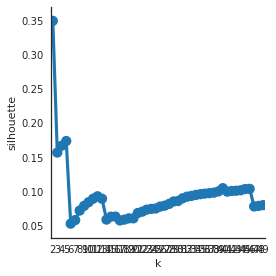

In [501]:
plt.close()
sns.factorplot(x='k',y='silhouette',data=go_solutions)
plt.show()

cluster 0
n =  17


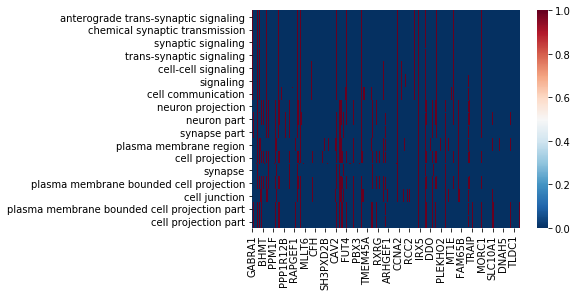

TTC40      1.000000
TTC30A     1.000000
SPAG17     1.000000
UBXN10     1.000000
FAM183A    1.000000
CBLN4      1.000000
LDB3       1.000000
EIF4G2     1.000000
CCDC37     0.800000
DNAH5      0.800000
SEPT9      0.800000
FAM126A    0.800000
PALMD      0.777778
RPH3A      0.777778
FJX1       0.750000
CHAT       0.750000
GPRIN1     0.750000
CYS1       0.714286
SYN2       0.687500
SNCB       0.666667
dtype: float64
['anterograde trans-synaptic signaling', 'chemical synaptic transmission', 'synaptic signaling', 'trans-synaptic signaling', 'cell-cell signaling', 'signaling', 'cell communication', 'neuron projection', 'neuron part', 'synapse part', 'plasma membrane region', 'cell projection', 'synapse', 'plasma membrane bounded cell projection', 'cell junction', 'plasma membrane bounded cell projection part', 'cell projection part']



cluster 1
n =  42


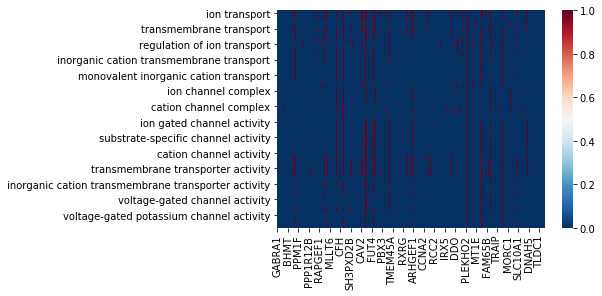

KCNS2      0.836735
KCNF1      0.836735
TMCO3      0.833333
KCNJ16     0.803922
PKD1L2     0.800000
SLC47A1    0.789474
NIPA2      0.789474
KCNH7      0.765957
FXYD6      0.764706
KCNK5      0.760870
FAM155B    0.758621
SLC9A5     0.750000
SLC9A2     0.750000
KCNJ4      0.745455
KCNN3      0.743590
KCNMB3     0.734694
KCNH5      0.734694
TRPM3      0.733333
KCNG2      0.732143
KCNJ15     0.729167
dtype: float64
['ion transport', 'ion transmembrane transport', 'regulation of membrane potential', 'transmembrane transport', 'inorganic ion transmembrane transport', 'cation transport', 'regulation of ion transport', 'metal ion transport', 'cation transmembrane transport', 'inorganic cation transmembrane transport', 'potassium ion transmembrane transport', 'cellular potassium ion transport', 'monovalent inorganic cation transport', 'potassium ion transport', 'regulation of ion transmembrane transport', 'ion channel complex', 'transmembrane transporter complex', 'transporter complex', 'cation

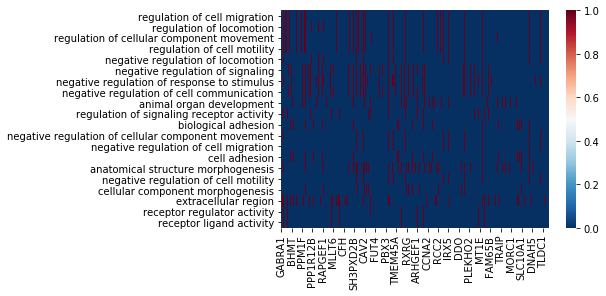

C1QL2       1.0
TMEM155     1.0
PODNL1      1.0
LCN15       1.0
ARSK        1.0
FNDC1       1.0
TEPP        1.0
GFOD1       1.0
DEFB124     1.0
OVCH2       1.0
SPINK9      1.0
KLK10       1.0
OLFML2B     1.0
ABHD15      1.0
PLEKHO2     1.0
TEX264      1.0
NXPE3       1.0
ADAMTSL1    1.0
GALNS       1.0
FAM60A      0.8
dtype: float64
['regulation of cell migration', 'regulation of locomotion', 'regulation of cellular component movement', 'regulation of cell motility', 'negative regulation of locomotion', 'negative regulation of signaling', 'negative regulation of response to stimulus', 'negative regulation of cell communication', 'animal organ development', 'regulation of signaling receptor activity', 'biological adhesion', 'negative regulation of cellular component movement', 'negative regulation of cell migration', 'cell adhesion', 'anatomical structure morphogenesis', 'negative regulation of cell motility', 'cellular component morphogenesis', 'extracellular region', 'receptor regulat

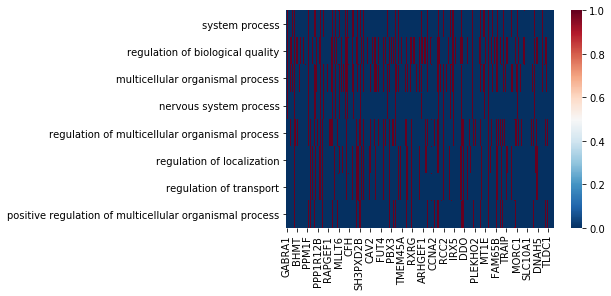

CRYZ        1.000000
AK3         1.000000
MYH8        1.000000
DLAT        1.000000
IRX2        1.000000
IMPG1       1.000000
KRTAP3-1    1.000000
CRYBB1      1.000000
TRIM58      0.714286
MLLT6       0.714286
SMPX        0.666667
STON1       0.666667
OBP2A       0.600000
LMOD3       0.555556
DDO         0.500000
HSD17B14    0.500000
PARP3       0.500000
PROZ        0.500000
KCNRG       0.500000
ADH4        0.500000
dtype: float64
['system process', 'regulation of biological quality', 'multicellular organismal process', 'nervous system process', 'regulation of multicellular organismal process', 'regulation of localization', 'regulation of transport', 'positive regulation of multicellular organismal process']



cluster 4
n =  3


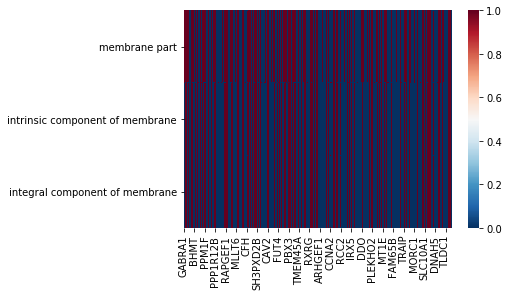

ACSL5       1.0
HOOK2       1.0
CLEC2L      1.0
SPCS2       1.0
WSCD1       1.0
CTXN3       1.0
SNX8        1.0
TMEM169     1.0
YIPF7       1.0
FAM189A1    1.0
TRAM2       1.0
TMEM71      1.0
MARCH3      1.0
FAM163A     1.0
TMEM215     1.0
DCBLD1      1.0
MS4A4A      1.0
TM6SF1      1.0
FAM209A     1.0
HS6ST2      1.0
dtype: float64
['membrane part', 'intrinsic component of membrane', 'integral component of membrane']



cluster 5
n =  8


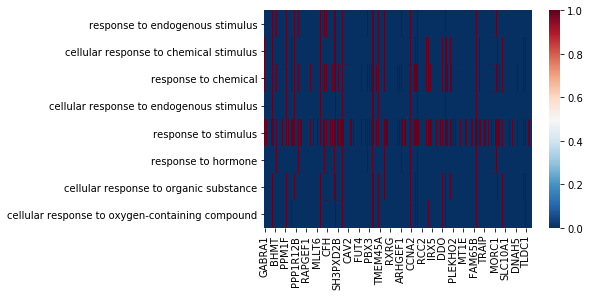

POLE2      1.000000
ZC3HAV1    1.000000
GMPR       1.000000
TRIM14     1.000000
GINS2      1.000000
SIRT5      1.000000
ABTB2      1.000000
SLFN11     1.000000
SPATA18    1.000000
ARPP21     1.000000
FBXO32     1.000000
USP45      1.000000
ADSSL1     1.000000
TFDP3      1.000000
LCN8       0.800000
EFHC2      0.800000
ACAP2      0.750000
CPNE2      0.750000
CPNE8      0.750000
CBX8       0.666667
dtype: float64
['response to endogenous stimulus', 'cellular response to chemical stimulus', 'response to chemical', 'cellular response to endogenous stimulus', 'response to stimulus', 'response to hormone', 'cellular response to organic substance', 'cellular response to oxygen-containing compound']



cluster 6
n =  4


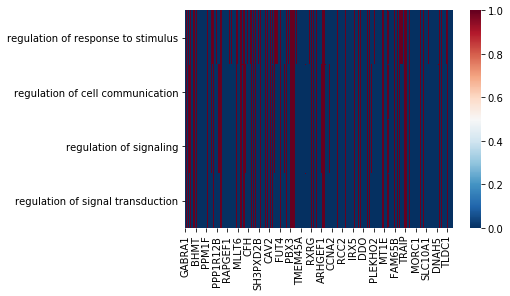

MCF2L2      1.000000
SH3BGRL     1.000000
PLEKHG4     0.800000
PLEKHG1     0.800000
GARNL3      0.800000
FAM53B      0.800000
JRK         0.800000
DEPDC7      0.800000
ST18        0.800000
AFAP1       0.666667
PEX5L       0.666667
ARHGEF17    0.666667
ARHGAP6     0.666667
FRMPD1      0.666667
MVB12B      0.571429
CLNK        0.571429
PIK3AP1     0.571429
PPP1R2      0.571429
PARG        0.500000
TBC1D16     0.500000
dtype: float64
['regulation of response to stimulus', 'regulation of cell communication', 'regulation of signaling', 'regulation of signal transduction']



cluster 7
n =  9


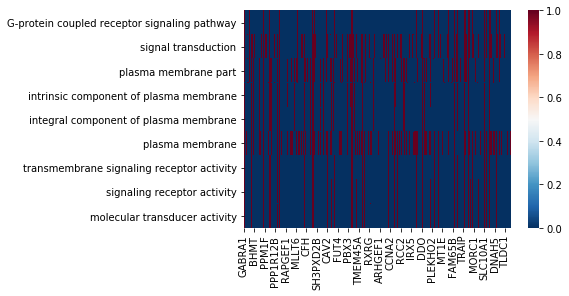

RGP1       1.000000
NR2F1      1.000000
MTFR1      1.000000
SPSB4      1.000000
VEPH1      1.000000
AMACR      1.000000
PHKA1      1.000000
ZNF385B    1.000000
FILIP1     1.000000
DTX2       1.000000
MRGPRF     0.857143
OR4C12     0.857143
OR2G6      0.800000
OR2B2      0.800000
OR4D2      0.750000
BRD8       0.750000
RXRG       0.750000
TRHR       0.750000
OR1K1      0.750000
IL22RA1    0.714286
dtype: float64
['G-protein coupled receptor signaling pathway', 'signal transduction', 'plasma membrane part', 'intrinsic component of plasma membrane', 'integral component of plasma membrane', 'plasma membrane', 'transmembrane signaling receptor activity', 'signaling receptor activity', 'molecular transducer activity']



cluster 8
n =  3


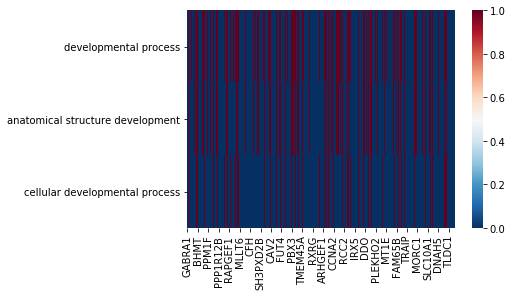

NHLH1      1.000000
CRYBA2     1.000000
NUDT7      1.000000
WDR62      1.000000
PRDM8      1.000000
GUSBP3     1.000000
PTER       1.000000
FAM9B      1.000000
ICA1L      1.000000
GGNBP1     0.750000
CYLC1      0.750000
FOXF2      0.750000
TDRD12     0.750000
ZIC5       0.750000
SOHLH1     0.750000
TRAPPC9    0.750000
NEUROD6    0.750000
NXF5       0.666667
ADAMTS6    0.666667
FBXO5      0.666667
dtype: float64
['developmental process', 'anatomical structure development', 'cellular developmental process']



cluster 9
n =  7


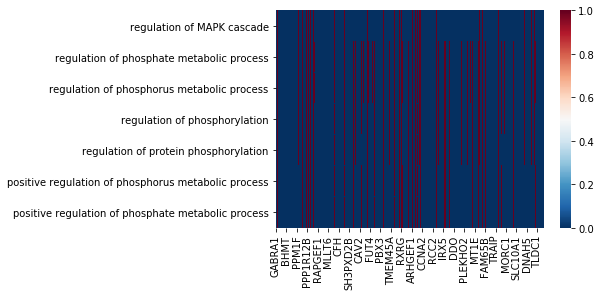

FAM212B    1.000000
CCNI       0.800000
CCNG2      0.800000
CLSPN      0.750000
MAP3K19    0.750000
PKIB       0.666667
PPP1R1C    0.666667
PHACTR2    0.666667
DOK7       0.600000
SAMD5      0.583333
DIRAS3     0.571429
MAP3K13    0.500000
TRIB2      0.500000
MAP3K10    0.500000
CEP192     0.500000
FAM20A     0.500000
MLXIPL     0.461538
CCNO       0.444444
LCP2       0.428571
CAMKK2     0.428571
dtype: float64
['regulation of MAPK cascade', 'regulation of phosphate metabolic process', 'regulation of phosphorus metabolic process', 'regulation of phosphorylation', 'regulation of protein phosphorylation', 'positive regulation of phosphorus metabolic process', 'positive regulation of phosphate metabolic process']



cluster 10
n =  1


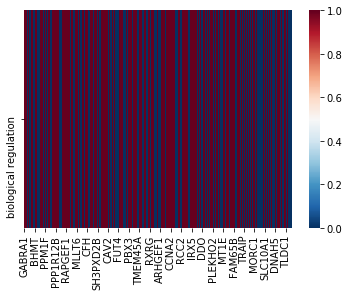

AFF1       1.0
ZBTB7C     1.0
ZNF215     1.0
IKZF2      1.0
ZNF391     1.0
ZNF669     1.0
PAOX       1.0
ADPRH      1.0
SMARCD2    1.0
DUX5       1.0
ZSCAN29    1.0
BEND5      1.0
TP53I3     1.0
PTTG2      1.0
JDP2       1.0
BACH2      1.0
ZSCAN20    1.0
ZNF556     1.0
ZNF688     1.0
FOXP4      1.0
dtype: float64
['biological regulation']



cluster 11
n =  132


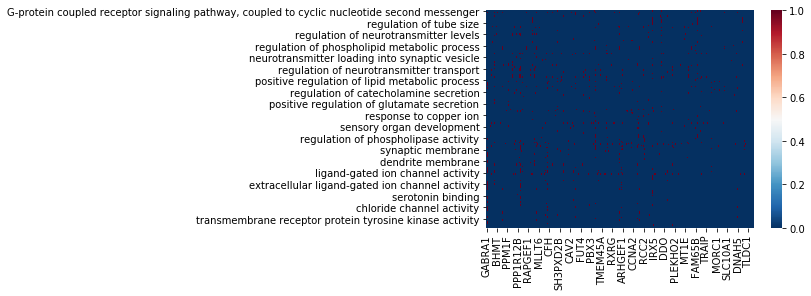

EFCAB1      1.000000
MEX3B       1.000000
FKBP7       1.000000
EFHB        1.000000
ADAMTS15    1.000000
HPCAL1      1.000000
OCM2        0.666667
LCN12       0.666667
FBLN2       0.666667
MT1E        0.636364
MT1A        0.636364
MT1B        0.636364
MT1F        0.636364
MT1M        0.636364
SLC25A21    0.571429
MT1G        0.562500
MT2A        0.538462
AGAP2       0.538462
SLC25A1     0.533333
SLC25A30    0.529412
dtype: float64
['G-protein coupled receptor signaling pathway, coupled to cyclic nucleotide second messenger', 'anion transport', 'phospholipase C-activating G-protein coupled receptor signaling pathway', 'membrane depolarization', 'regulation of blood vessel diameter', 'regulation of tube diameter', 'regulation of blood vessel size', 'regulation of tube size', 'smooth muscle contraction', 'cellular response to zinc ion', 'behavior', 'positive regulation of phosphatidylinositol biosynthetic process', 'vascular process in circulatory system', 'detoxification of copper ion', 

In [24]:
k = 12 # based on silhouette and perc_hits
X = go_gsea.T.values
connectivity = kneighbors_graph(X, n_neighbors=100, mode='distance', 
                                    metric = 'jaccard', include_self=False)
clusterer = AgglomerativeClustering(n_clusters=k, connectivity=connectivity)
cluster_labels = clusterer.fit_predict(X)
mtx = pandas.DataFrame(go_gsea.T, copy=True)
mtx.loc[:,'label'] = cluster_labels
for i in np.unique(mtx.label):
    plt.close()
    print('cluster',i)
    clus_data = mtx[mtx.label==i][mtx.columns[:-1]]
    print('n = ',len(clus_data))
    sns.heatmap(pandas.DataFrame(clus_data),
               cmap = 'RdBu_r')
    plt.show()
    top_hits = (clus_data.sum()/go_gsea.T.sum()).sort_values(ascending=False).head(20)
    print(top_hits)
    print(clus_data.index.tolist())
    #for x in clus_data.index:
    #    print(x)
    print('\n\n')
    
#     xp_mtx = g3.data2d.loc[[x for x in g3.data2d.index if x in probes[probes.gene_symbol.isin(clus_data.index.tolist())
#                                                                      ].index]].reindex(columns=xp.columns)
#     rs = [stats.pearsonr(xp_mtx.loc[i],df.position_along_hipp_AP_axis.values)[0] for i in xp_mtx.index]
#     ap = np.array(['a' if x > 0 else 'p' for x in rs])
#     amtx = xp_mtx.loc[xp_mtx.index[ap=='a']]
#     pmtx = xp_mtx.loc[xp_mtx.index[ap=='p']]
#     print('%s anterior, %s posterior'%(len(amtx),len(pmtx)))
#     print('anterior:', probes.loc[amtx.index,'gene_symbol'].unique())
#     print('posterior:', probes.loc[pmtx.index,'gene_symbol'].unique())
#     phdf = pandas.DataFrame(df,copy=True)
#     phdf.loc[:,'a_gxp'] = amtx.mean().values
#     phdf.loc[:,'p_gxp'] = pmtx.mean().values
#     ar = stats.pearsonr(phdf.a_gxp,phdf.position_along_hipp_AP_axis)[0]**2
#     pr = stats.pearsonr(phdf.p_gxp,phdf.position_along_hipp_AP_axis)[0]**2
#     print('anterior r2 = %s, posterior r2 = %s'%(ar,pr))
#     for subfield in subfields:
#         ars = stats.pearsonr(phdf[phdf.structure_acronym==subfield]['a_gxp'],
#                              df[df.structure_acronym==subfield].position_along_hipp_AP_axis)[0]**2
#         prs = stats.pearsonr(phdf[phdf.structure_acronym==subfield]['p_gxp'],
#                              df[df.structure_acronym==subfield].position_along_hipp_AP_axis)[0]**2
#         print('%s anterior = %s, posterior = %s'%(subfield,ars,prs))

#     sns.heatmap(amtx,cmap='RdBu_r')
#     plt.show()
#     plt.close()
#     sns.heatmap(pmtx,cmap='RdBu_r')
#     plt.show()

In [26]:
# WARNING: THIS TAKES A VERRRRY LONG TIME TO RUN!

n_iter = 100
nulls2 = np.zeros((len(mtx.label.unique())*2,n_iter))
for i in np.unique(mtx.label):
    print('cluster',i)
    weighter = pandas.DataFrame(columns = ['weight'])
    clus_data = mtx[mtx.label==i][mtx.columns[:-1]]
    top_hits = (clus_data.sum()/go_gsea.T.sum()).sort_values(ascending=False)
    for g in top_hits.index:
        inds = probes[probes.gene_symbol==g].index
        for ind in inds:
            if ind in mod_genes.index:
                weighter.loc[ind,'weight'] = top_hits[g]
                weighter.loc[ind,'AP'] = mod_genes.loc[ind,'ant-post']
    for ap in ['anterior','posterior']:
        row_idx = i*2
        if ap == 'posterior':
            row_idx += 1
        wdf = weighter[weighter.AP==ap]
        X = bigdf.loc[wdf.index].T
        cluster_score = (X * wdf.weight.values).mean(1).values
        gdf.loc[:,'Set3_C%s_%s'%(i,ap)] = cluster_score
        print('finding nulls')
        for p in range(n_iter):
            np.random.shuffle(wdf.weight.values)
            cluster_score = (X * wdf.weight.values).mean(1).values
            r2 = stats.pearsonr(cluster_score[mcoords_idx], 
                                np.array(vex['cx_vector']))[0]**2
            nulls2[row_idx,p] = r2

cluster 0
finding nulls
finding nulls
cluster 1
finding nulls
finding nulls
cluster 2
finding nulls
finding nulls
cluster 3
finding nulls
finding nulls
cluster 4
finding nulls
finding nulls
cluster 5
finding nulls
finding nulls
cluster 6
finding nulls
finding nulls
cluster 7
finding nulls
finding nulls
cluster 8
finding nulls
finding nulls
cluster 9
finding nulls
finding nulls
cluster 10
finding nulls
finding nulls
cluster 11
finding nulls
finding nulls


In [76]:
cr3.sort_values(['direction','cluster'],inplace=True)
cr3.loc[:,'Title'] = ['C0: Peptide Antigen Binding',
                      'C1: Amine Transport',
                      'C2: Response to Cu ions',
                      'C3: Anion Transporter Activity',
                      'C4: Cell Motility',
                      'C5: Serotonin Binding',
                      'C6: GABA Activity',
                      'C7: Vascular Growth Factor Activity',
                      'C8: Signal Transduction',
                      'C9: K Channel Activity',
                      'C10: Phosphorylation',
                      'C11: Lipid Transport'] * 2

In [85]:
cr3.sort_values('index',inplace=True)

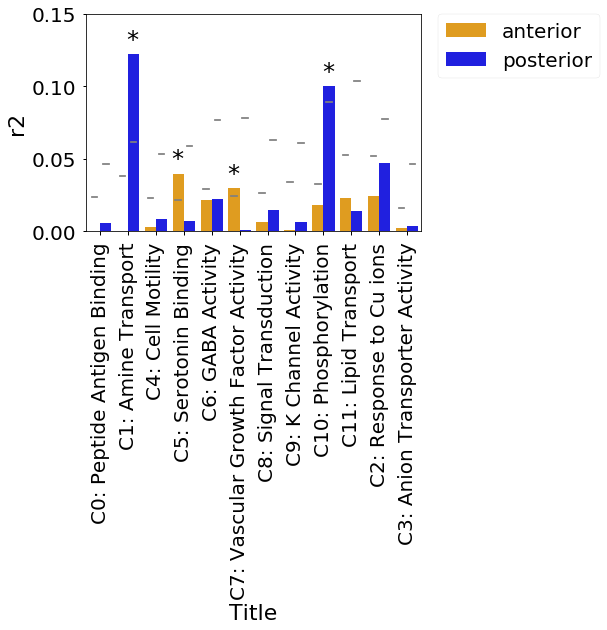

In [88]:
sns.set_context('notebook',font_scale=2)
plt.close()
g = sns.barplot(x='Title',y='r2',hue='direction',data=cr3,palette=['orange','blue'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
for i in cr3.index:
    row_idx = ((i+0.0001) / 2)
    if i%2==0:
        row_idx -= 0.2
    else:
        row_idx -= 0.3
    plt.plot([row_idx-0.1,row_idx+0.1],[cr3.loc[i,'null'],cr3.loc[i,'null']],'gray')
    if cr3.loc[i,'null'] < cr3.loc[i,'r2']:
        plt.text(row_idx-0.25, cr3.loc[i,'r2'] + 0.005, '*')
plt.ylim(0,0.15)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

#plt.savefig(os.path.join(fig_dir,'Disease_CR3.pdf'),
#           bbox_inches='tight')
plt.show()

# Revision: Look at types of gene distributions

The objective here is to see if there are different types of expression patterns along the hippocampal longitudinal axis besides linear gradients, and to see what the distribution of expression patterns is for each gene set. We will cluster all genes in Sets 1-4 and then examine the expression clusters and cluster membership within each gene set.

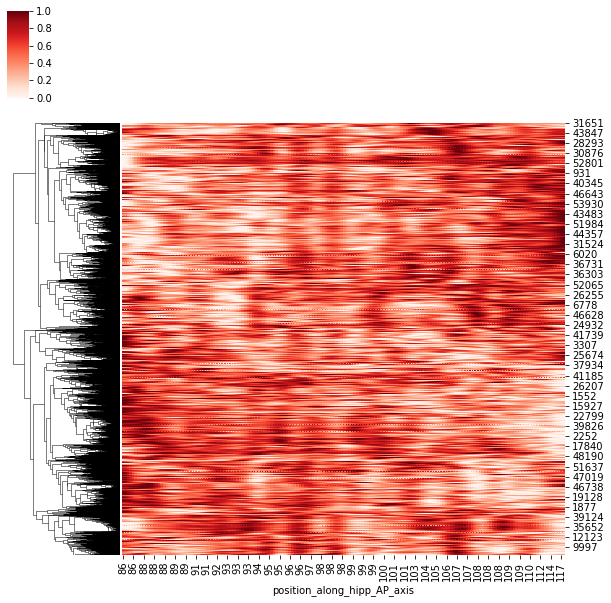

In [25]:
# GATHER ALL GENES

# Identify gene set
jnk = xp.loc[mod_genes[(mod_genes.step<5) \
                      # &(mod_genes['ant-post']=='anterior')
                      ]['probe_ind'],
             xp.columns[df.sort_values('position_along_hipp_AP_axis').index]]

# # Smooth the data along X (axis position) with a 3mm kernel for easier viewing/clustering
sjnk = pandas.DataFrame(ndimage.gaussian_filter1d(jnk,3,1), 
                        #index = probes.loc[jnk.index,'gene_symbol'], 
                        index = jnk.index,
                        columns = df.sort_values('position_along_hipp_AP_axis').position_along_hipp_AP_axis)
# Cluster and plot
plt.close()
g = sns.clustermap(sjnk,
               #jnk,
               col_cluster=False, metric='correlation', standard_scale=0,
               cmap='Reds')
plt.show()

In [235]:
# mtx2 = pandas.DataFrame(dat.values, copy=True)
# mtx2.loc[:,'label'] = cluster_labels

In [623]:
ks = range(2,50)
solutions = pandas.DataFrame(index = ks, columns = ['silhouette', 'CH_index',
                                                             'mean_size','min_size','max_size'])
X = g.data2d
for k in ks:
    # Perform cluster analysis
    clusterer = SpectralClustering(n_clusters=k, random_state=123)
    #cluster = GaussianMixture(n_components=k, random_state=123)
    cluster_labels = clusterer.fit_predict(X)
    # silhouette
    solutions.loc[k,'silhouette'] = silhouette_score(X, cluster_labels)
    # CH Index
    solutions.loc[k,'CH_index'] = calinski_harabaz_score(X, cluster_labels)
    # Get information on cluster size
    mtx2 = pandas.DataFrame(X.values, copy=True)
    mtx2.loc[:,'label'] = cluster_labels
    sizes = []
    for i in np.unique(mtx2.label):
        clus_data = mtx2[mtx2.label==i][mtx2.columns[:-1]]
        sizes.append(len(clus_data))
    # SIZES
    solutions.loc[k,'mean_size'] = np.mean(sizes)
    solutions.loc[k,'min_size'] = np.min(sizes)
    solutions.loc[k,'max_size'] = np.max(sizes)
    print('finished',k)

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


finished 2


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


finished 3


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


finished 4


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


finished 5


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


finished 6


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


finished 7


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


finished 8


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


finished 9


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


finished 10


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


finished 11


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


finished 12


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


finished 13


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


finished 14


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


finished 15


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


finished 16


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


finished 17


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


finished 18


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


finished 19


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


finished 20


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


finished 21


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


finished 22


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


finished 23


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


finished 24


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


finished 25


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


finished 26


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


finished 27


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


finished 28


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


finished 29


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


finished 30


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


finished 31


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


finished 32


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


finished 33


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


finished 34


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


finished 35


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


finished 36


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


finished 37


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


finished 38


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


finished 39


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


finished 40


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


finished 41


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


finished 42


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


finished 43


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


finished 44


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


finished 45


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


finished 46


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


finished 47


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


finished 48
finished 49


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


In [624]:
solutions.loc[:,'k'] = solutions.index

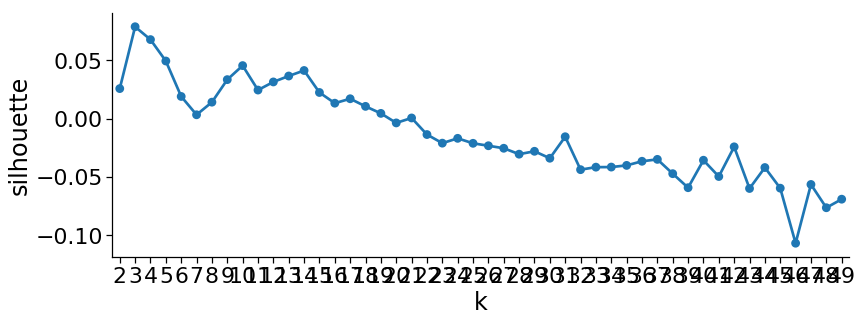

In [816]:
plt.close()
sns.catplot(x='k',y='silhouette',data=solutions, kind='point', aspect=2.5)
plt.show()

In [819]:
solutions

silhouette CH_index mean_size min_size max_size   k
2      0.025666  61.3277      2500       75     4925   2
3     0.0787285  503.246   1666.67       75     2539   3
4     0.0676957  478.306      1250       75     2283   4
5     0.0493233  360.049      1000        3     2280   5
6     0.0189176  301.659   833.333        3     2300   6
7    0.00319857  253.391   714.286        3     2291   7
8     0.0140179  264.379       625        3     2045   8
9     0.0333586   274.25   555.556        3     1898   9
10    0.0453878  276.208       500        3     1589  10
11    0.0244065  213.387   454.545        2     1931  11
12    0.0313715  227.795   416.667        2     1723  12
13    0.0364583  225.706   384.615        2     1768  13
14    0.0411891  221.559   357.143        2     1270  14
15    0.0223227  195.572   333.333        2     1210  15
16    0.0131405  175.725     312.5        2     1615  16
17    0.0169512  169.101   294.118        2     1366  17
18    0.0104197  161.134   277.778        2     1275  18
19   0.00439308  153.877   263.158        2     1266  19
20  -0.00377885  150.638       250        2     1452  20
21  0.000466302  151.808   238.095        2     1404  21
22   -0.0137591  134.235   227.273        2     1604  22
23   -0.0211445  126.825   217.391        2     1630  23
24   -0.0170127   125.19   208.333        2     1415  24
25   -0.0212792  118.024       200        2     1454  25
26   -0.0233709  120.229   192.308        2     1526  26
27   -0.0255268  119.702   185.185        2     1388  27
28   -0.0306033  114.212   178.571        2     1234  28
29   -0.0281275  110.385   172.414        2     1456  29
30   -0.0340858  106.902   166.667        1     1489  30
31   -0.0156438   120.19    161.29        2     1154  31
32   -0.0438905  100.137    156.25        1     1483  32
33   -0.0417388  98.8356   151.515        1     1446  33
34   -0.0416677  96.7654   147.059        1     1355  34
35   -0.0402261  97.6519   142.857        2     1375  35
36    -0.036689  97.2939   138.889        2     1410  36
37     -0.03506  96.0981   135.135        2     1390  37
38   -0.0473302  84.4193   131.579        2     1425  38
39   -0.0593631  79.1946   128.205        2     1515  39
40   -0.0358005  91.1914       125        2     1421  40
41   -0.0497591  80.4133   121.951        2     1514  41
42   -0.0243045  95.0762   119.048        2     1162  42
43   -0.0600386  75.6672   116.279        1     1524  43
44   -0.0420628  84.7719   113.636        2     1302  44
45   -0.0597707  74.4704   111.111        1     1145  45
46     -0.10698  47.4508   108.696        2     2092  46
47   -0.0565836  70.6187   106.383        2     1101  47
48   -0.0765507  61.1711   104.167        2     1601  48
49   -0.0692227  67.2989   102.041        2     1335  49

In [29]:
k = 14
X = g.data2d
clusterer = SpectralClustering(n_clusters=k, random_state=123, 
                                   affinity='nearest_neighbors', n_neighbors=20)
cluster_labels = clusterer.fit_predict(X)
mtx = pandas.DataFrame(X.values, copy=True)
mtx.loc[:,'label'] = cluster_labels
mtx.index = X.index

In [49]:
# ## SAVE CLUSTER MEMBERSHIP FOR A SUPPLEMENTARY TABLE
# mod_genes.loc[mtx.index,'Expression_Cluster'] = mtx.label.values
# mod_genes.to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NCRevisions/Table_SXPCluster.csv')

In [32]:
mtx.loc[mod_genes[mod_genes.step==1].index,'label'].value_counts()

3     34
6     27
1     13
2     12
8     11
13     3
9      1
Name: label, dtype: int64

In [50]:
mtx.columns = mtx.columns = jnk.columns.tolist() + ['label']
mtx.loc['ap',:] = sjnk.columns.tolist() + ['label']

In [411]:
# mod_genes[(mod_genes.gene_symbol.isin(['OPRK1', 'GAL', 'VGLL3', 'A_23_P213527', 
#                                        'AQP3', 'GPR26', 'NR2F2', 'GPR39', 'DDC', 
#                                        'GEFT', 'SYTL2', 'KLK7', 'A_24_P102119', 
#                                        'LYPD1', 'PIRT', 'CD36', 'LXN', 'MYB', 
#                                        'RP11-45B20.3', 'KCNG1', 'C1orf187', 
#                                        'C1QL1', 'PYDC1', 'NRG1', 'PDLIM5'])) & (mod_genes.step==1)]

#### Retrive Clusters for Set 1

In [59]:

go_proc = os.path.join('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/GOPROCESS_SET1.xlsx')
gos = [go_proc]

# Consolidate into a dataframe
go_gsea = hap.prepare_GO_terms(top_100, gos, probes)
go_gsea.head()

tissue morphogenesis  regulation of multicellular organismal process  \
GAL                       0.0                                             1.0   
ONECUT2                   0.0                                             0.0   
PDLIM5                    0.0                                             1.0   
COL5A2                    0.0                                             1.0   
GREM2                     0.0                                             0.0   

         behavior  negative regulation of developmental growth  \
GAL           1.0                                          1.0   
ONECUT2       0.0                                          0.0   
PDLIM5        0.0                                          0.0   
COL5A2        0.0                                          0.0   
GREM2         0.0                                          0.0   

         tissue development  tube morphogenesis  \
GAL                     0.0                 0.0   
ONECUT2                 0.0                 0.0   
PDLIM5                  0.0                 0.0   
COL5A2                  0.0                 0.0   
GREM2                   0.0                 0.0   

         negative regulation of cell growth  \
GAL                                     1.0   
ONECUT2                                 0.0   
PDLIM5                                  0.0   
COL5A2                                  0.0   
GREM2                                   0.0   

         anatomical structure morphogenesis  morphogenesis of an epithelium  \
GAL                                     0.0                             0.0   
ONECUT2                                 1.0                             0.0   
PDLIM5                                  0.0                             0.0   
COL5A2                                  1.0                             0.0   
GREM2                                   1.0                             0.0   

         branching morphogenesis of an epithelial tube  \
GAL                                                0.0   
ONECUT2                                            0.0   
PDLIM5                                             0.0   
COL5A2                                             0.0   
GREM2                                              0.0   

         negative regulation of axonogenesis  \
GAL                                      0.0   
ONECUT2                                  0.0   
PDLIM5                                   0.0   
COL5A2                                   0.0   
GREM2                                    0.0   

         morphogenesis of a branching epithelium  
GAL                                          0.0  
ONECUT2                                      0.0  
PDLIM5                                       0.0  
COL5A2                                       0.0  
GREM2                                        0.0

Find lowess curves over the smoothed expression data, plot expression patterns by cluster

In [60]:
dat = g.data2d.loc[mod_genes[mod_genes.step==1].index]
cont = []
for i in range(len(dat)):
    lo = lowess(dat.iloc[i].values,
                dat.columns.values,
                delta=.01,
               frac=0.2)
    _ = pandas.DataFrame(lo,columns=['y','x'])
    _.loc[:,'cluster'] = [mtx.loc[mod_genes[mod_genes.step==1].index,'label'].values[i]] * dat.shape[-1]
    cont.append(_)
jnk = pandas.concat(cont)
cnames = []
pnames = []
for i,lab in enumerate(mtx.loc[mod_genes[mod_genes.step==1].index].label.values):
    cnames += ([lab]*dat.shape[-1])
    pnames += ([mtx.index[i]]*dat.shape[-1])
jnk.loc[:,'probe'] = pnames
jnk.loc[:,'cluster'] = cnames

In [761]:
# df.loc[:,'SampID'] = ['%s_%s'%(df.loc[x,'donor'],df.loc[x,'sample']) for x in df.index]
# for lab, n in mtx.loc[mod_genes[mod_genes.step==1].index,'label'].value_counts().iteritems():
#     mini_mat = mtx.loc[mod_genes[mod_genes.step==1].index][mtx.loc[mod_genes[mod_genes.step==1].index]['label']==lab]
#     for subfield in df.structure_acronym.unique():
#         samps = df[df.structure_acronym==subfield]['SampID']
#         pos = df[df.structure_acronym==subfield]['position_along_hipp_AP_axis']
#         y = mini_mat[samps].mean(0)
#         r2 = stats.pearsonr(pos,y)[0]**2
#         print('Cluster %s: %s --> R2 = %s'%(lab,subfield,r2))


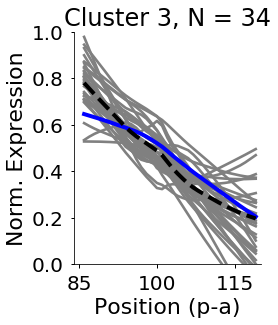

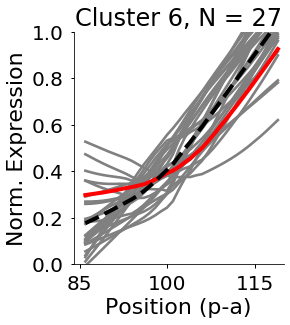

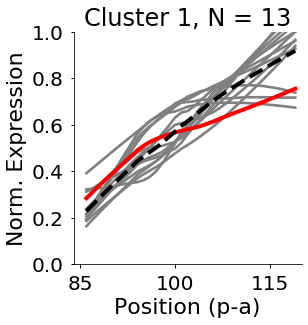

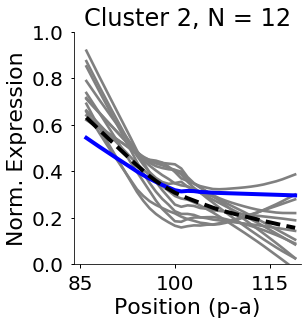

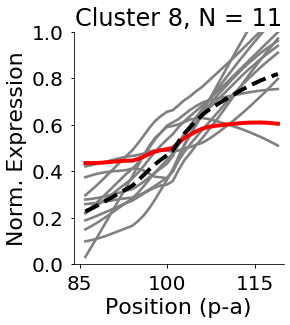

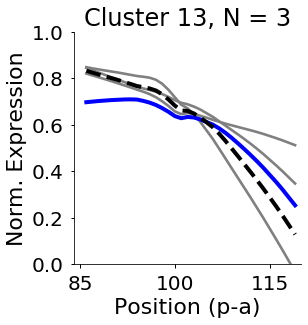

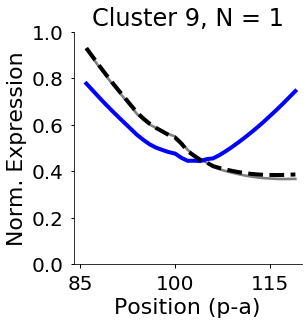

In [62]:
sns.set_context('notebook',font_scale=2)

cluster_sets = pandas.DataFrame()
count = 0
for lab, n in mtx.loc[mod_genes[mod_genes.step==1].index,'label'].value_counts().iteritems():
    mini_matA = mtx[mtx['label']==lab]
    mini_matB = mtx.loc[mod_genes[mod_genes.step==1].index][mtx.loc[mod_genes[mod_genes.step==1].index]['label']==lab]
    ap = mod_genes.loc[mini_matA.index,'ant-post'].value_counts().index[0]
    if ap == 'anterior':
        color = 'red'
    else:
        color = 'blue'
    plt.close()
    #plt.subplots(figsize=(5,5))
    fig = sns.lmplot(x='y', y='x', data=jnk[jnk.cluster==lab],lowess=True, col='cluster',
           markers='', hue='probe', palette=['gray'],size=5)
    fig._legend.remove()
    fig.set_xticklabels([85,100,115])
    sns.regplot(x=mtx.loc['ap'][:-1].values.astype(float),
                y = mini_matA[mtx.columns[:-1]].mean(0),
               lowess=True,
                marker='',
                color=color,
                line_kws = {'linewidth':4})
    sns.regplot(x=mtx.loc['ap'][:-1].values.astype(float),
                y = mini_matB[mtx.columns[:-1]].mean(0),
               lowess=True,
                marker='',
                color='black',
               line_kws = {'linestyle':'--', 'linewidth':4})
    
    plt.xlim(84,120)
    plt.ylim(0,1)    
    plt.title('Cluster %s, N = %s'%(int(lab), n))
    plt.xlabel('Position (p-a)')
    plt.ylabel('Norm. Expression')
    plt.xticks([85,100,115])    
    #plt.savefig(os.path.join(fig_dir,'Set1Clus_C%s.pdf'%lab),
    #           bbox_inches='tight')
    plt.show()
    genes = mod_genes.loc[set(mod_genes[mod_genes.step==1].index) & set(mini_matA.index)
                                        ]['gene_symbol'].unique().tolist()
#     print(genes,'\n')
#     print((go_gsea.loc[(set(go_gsea.index) & set(genes))].sum(0) / go_gsea.sum(0).values).sort_values(ascending=False))
    cluster_sets.loc[count,'Set'] = 1
    cluster_sets.loc[count,'Cluster'] = lab
    cluster_sets.loc[count,'N'] = n
    count += 1

#### Do the same for Set 2

In [63]:

go_proc = '/home/users/jvogel/git/Hippocampus_AP_Axis/Data/GOPROCESS.xls'
go_comp = '/home/users/jvogel/git/Hippocampus_AP_Axis/Data/GOCOMPONENT.xls'
go_func = '/home/users/jvogel/git/Hippocampus_AP_Axis/Data/GOFUNCTION.xls'
gos = [go_proc, go_comp, go_func]

# Consolidate into a dataframe
go_gsea = hap.prepare_GO_terms(top_100_600, gos, probes)
go_gsea.head()

anterograde trans-synaptic signaling  chemical synaptic transmission  \
PTX3                                     0.0                             0.0   
GABRA1                                   1.0                             1.0   
PDCD6                                    0.0                             0.0   
HTR2C                                    1.0                             1.0   
TAC1                                     1.0                             1.0   

        synaptic signaling  trans-synaptic signaling  nervous system process  \
PTX3                   0.0                       0.0                     0.0   
GABRA1                 1.0                       1.0                     1.0   
PDCD6                  0.0                       0.0                     0.0   
HTR2C                  1.0                       1.0                     0.0   
TAC1                   1.0                       1.0                     1.0   

        system process  behavior  signal transduction  cell communication  \
PTX3               0.0       0.0                  0.0                 0.0   
GABRA1             1.0       0.0                  1.0                 1.0   
PDCD6              0.0       0.0                  1.0                 0.0   
HTR2C              0.0       1.0                  1.0                 1.0   
TAC1               1.0       1.0                  1.0                 1.0   

        multicellular organismal process            ...              \
PTX3                                 0.0            ...               
GABRA1                               1.0            ...               
PDCD6                                0.0            ...               
HTR2C                                1.0            ...               
TAC1                                 1.0            ...               

        chemorepellent activity  ammonium ion binding  \
PTX3                        0.0                   0.0   
GABRA1                      0.0                   0.0   
PDCD6                       0.0                   0.0   
HTR2C                       0.0                   1.0   
TAC1                        0.0                   0.0   

        chloride channel activity  ligand-gated cation channel activity  \
PTX3                          0.0                                   0.0   
GABRA1                        1.0                                   0.0   
PDCD6                         0.0                                   0.0   
HTR2C                         0.0                                   0.0   
TAC1                          0.0                                   0.0   

        GABA-gated chloride ion channel activity  \
PTX3                                         0.0   
GABRA1                                       1.0   
PDCD6                                        0.0   
HTR2C                                        0.0   
TAC1                                         0.0   

        ion transmembrane transporter activity  hormone activity  \
PTX3                                       0.0               0.0   
GABRA1                                     1.0               0.0   
PDCD6                                      0.0               0.0   
HTR2C                                      0.0               0.0   
TAC1                                       0.0               0.0   

        excitatory extracellular ligand-gated ion channel activity  \
PTX3                                                  0.0            
GABRA1                                                0.0            
PDCD6                                                 0.0            
HTR2C                                                 0.0            
TAC1                                                  0.0            

        G-protein coupled peptide receptor activity  GTPase inhibitor activity  
PTX3                                            0.0                        0.0  
GABRA1                                          0.0      

In [55]:
dat = g.data2d.loc[mod_genes[mod_genes.step==2].index]
cont = []
for i in range(len(dat)):
    lo = lowess(dat.iloc[i].values,
                dat.columns.values,
                delta=.01,
               frac=0.2)
    _ = pandas.DataFrame(lo,columns=['y','x'])
    _.loc[:,'cluster'] = [mtx.loc[mod_genes[mod_genes.step==2].index,'label'].values[i]] * dat.shape[-1]
    cont.append(_)
jnk = pandas.concat(cont)
cnames = []
pnames = []
for i,lab in enumerate(mtx.loc[mod_genes[mod_genes.step==2].index].label.values):
    cnames += ([lab]*dat.shape[-1])
    pnames += ([mtx.index[i]]*dat.shape[-1])
jnk.loc[:,'probe'] = pnames
jnk.loc[:,'cluster'] = cnames

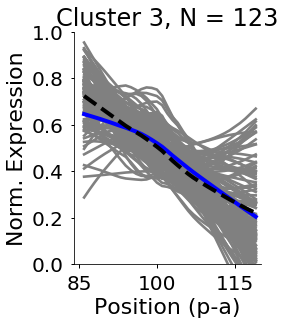

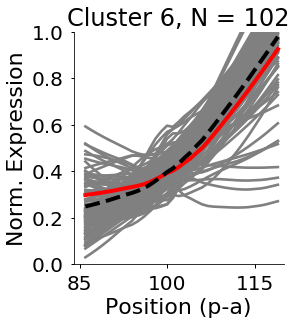

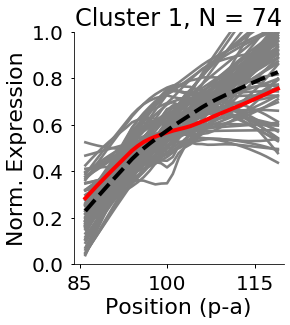

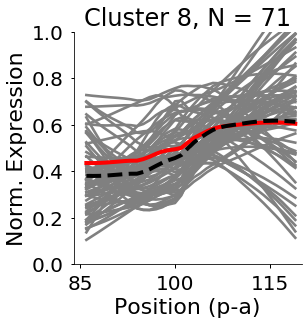

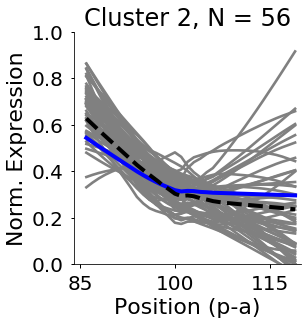

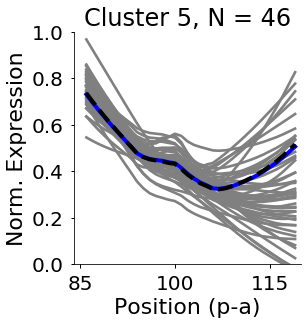

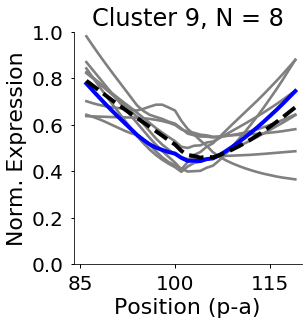

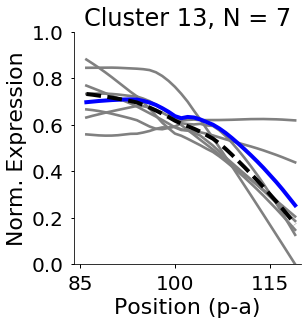

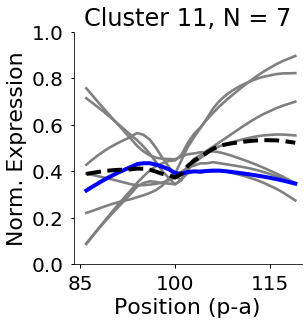

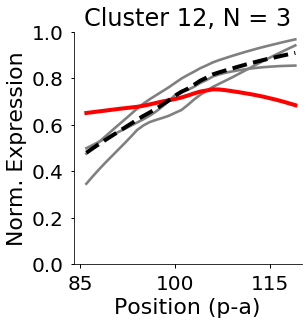

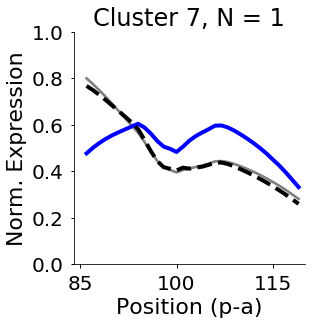

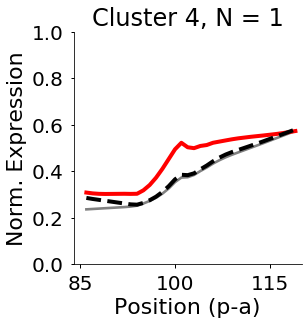

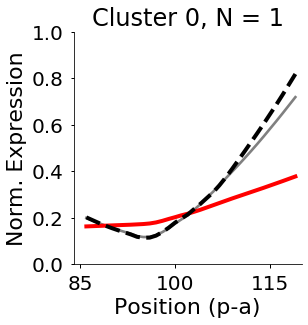

In [58]:
sns.set_context('notebook',font_scale=2)

count = 7
for lab, n in mtx.loc[mod_genes[mod_genes.step==2].index,'label'].value_counts().iteritems():
    mini_matA = mtx[mtx['label']==lab]
    mini_matB = mtx.loc[mod_genes[mod_genes.step==2].index][mtx.loc[mod_genes[mod_genes.step==2].index]['label']==lab]
    ap = mod_genes.loc[mini_matA.index,'ant-post'].value_counts().index[0]
    if ap == 'anterior':
        color = 'red'
    else:
        color = 'blue'
    plt.close()
    fig = sns.lmplot(x='y', y='x', data=jnk[jnk.cluster==lab],lowess=True, col='cluster',
           markers='', hue='probe', palette=['gray'])
    fig._legend.remove()
    fig.set_xticklabels([85,100,115])
    sns.regplot(x=mtx.loc['ap'][:-1].values.astype(float),
                y = mini_matA[mtx.columns[:-1]].mean(0),
               lowess=True,
                marker='',
                color=color,
                line_kws = {'linewidth':4})
    sns.regplot(x=mtx.loc['ap'][:-1].values.astype(float),
                y = mini_matB[mtx.columns[:-1]].mean(0),
               lowess=True,
                marker='',
                color='black',
               line_kws = {'linestyle':'--', 'linewidth':4})
    
    plt.xlim(84,120)
    plt.ylim(0,1)    
    plt.title('Cluster %s, N = %s'%(int(lab), n))
    plt.xlabel('Position (p-a)')
    plt.ylabel('Norm. Expression')
    plt.xticks([85,100,115])    
    #plt.savefig(os.path.join(fig_dir,'Set2Clus_C%s.pdf'%lab),
    #           bbox_inches='tight')
    plt.show()
    genes = mod_genes.loc[set(mod_genes[mod_genes.step==2].index) & set(mini_matA.index)
                                        ]['gene_symbol'].unique().tolist()
    #print(genes,'\n')
    #print((go_gsea.loc[(set(go_gsea.index) & set(genes))].sum(0) / go_gsea.sum(0).values).sort_values(ascending=False).head(15))
    cluster_sets.loc[count,'Set'] = 2
    cluster_sets.loc[count,'Cluster'] = lab
    cluster_sets.loc[count,'N'] = n
    count += 1

#### Retrive Clusters for Set 3

In [806]:

go_proc = '/home/users/jvogel/git/Hippocampus_AP_Axis/Data/GOPROCESS_6_2700.xlsx'
go_comp = '/home/users/jvogel/git/Hippocampus_AP_Axis/Data/GOCOMPONENT_6_2700.xlsx'
go_func = '/home/users/jvogel/git/Hippocampus_AP_Axis/Data/GOFUNCTION_6_2700.xlsx'
gos = [go_proc, go_comp, go_func]

# Consolidate into a dataframe
go_gsea = hap.prepare_GO_terms(top_600_2700, gos, probes)
go_gsea.head()

anterograde trans-synaptic signaling  chemical synaptic transmission  \
GABRA1                                    1.0                             1.0   
COL25A1                                   0.0                             0.0   
CPNE8                                     0.0                             0.0   
CARTPT                                    1.0                             1.0   
HTR2C                                     1.0                             1.0   

         synaptic signaling  trans-synaptic signaling  system process  \
GABRA1                  1.0                       1.0             1.0   
COL25A1                 0.0                       0.0             0.0   
CPNE8                   0.0                       0.0             0.0   
CARTPT                  1.0                       1.0             0.0   
HTR2C                   1.0                       1.0             0.0   

         cell-cell signaling  ion transport  signaling  cell communication  \
GABRA1                   1.0            1.0        1.0                 1.0   
COL25A1                  0.0            0.0        0.0                 0.0   
CPNE8                    0.0            0.0        0.0                 0.0   
CARTPT                   1.0            0.0        1.0                 1.0   
HTR2C                    1.0            1.0        1.0                 1.0   

         ion transmembrane transport  \
GABRA1                           1.0   
COL25A1                          0.0   
CPNE8                            0.0   
CARTPT                           0.0   
HTR2C                            1.0   

                                      ...                                \
GABRA1                                ...                                 
COL25A1                               ...                                 
CPNE8                                 ...                                 
CARTPT                                ...                                 
HTR2C                                 ...                                 

         carboxylic acid transmembrane transporter activity  \
GABRA1                                                 0.0    
COL25A1                                                0.0    
CPNE8                                                  0.0    
CARTPT                                                 0.0    
HTR2C                                                  0.0    

         monovalent inorganic cation transmembrane transporter activity  \
GABRA1                                                 0.0                
COL25A1                                                0.0                
CPNE8                                                  0.0                
CARTPT                                                 0.0                
HTR2C                                                  0.0                

         cGMP binding  chloride transmembrane transporter activity  \
GABRA1            0.0                                          1.0   
COL25A1           0.0                                          0.0   
CPNE8             0.0                                          0.0   
CARTPT            0.0                                          0.0   
HTR2C             0.0                                          0.0   

         transmembrane receptor protein tyrosine kinase activity  \
GABRA1                                                 0.0         
COL25A1                                                0.0         
CPNE8                                                  0.0         
CARTPT                                                 0.0         
HTR2C                                                  0.0         

         organic anion transmembrane transporter activity  \
GABRA1                                                0.0   
COL25A1                                               0.0   
CPNE8                                                 0.0   
CARTPT            

In [807]:
dat = g.data2d.loc[mod_genes[mod_genes.step==3].index]
cont = []
for i in range(len(dat)):
    lo = lowess(dat.iloc[i].values,
                dat.columns.values,
                delta=.01,
               frac=0.2)
    _ = pandas.DataFrame(lo,columns=['y','x'])
    _.loc[:,'cluster'] = [mtx.loc[mod_genes[mod_genes.step==3].index,'label'].values[i]] * dat.shape[-1]
    cont.append(_)
jnk = pandas.concat(cont)
cnames = []
pnames = []
for i,lab in enumerate(mtx.loc[mod_genes[mod_genes.step==3].index].label.values):
    cnames += ([lab]*dat.shape[-1])
    pnames += ([mtx.index[i]]*dat.shape[-1])
jnk.loc[:,'probe'] = pnames
jnk.loc[:,'cluster'] = cnames

In [65]:
sns.set_context('notebook',font_scale=2)

count = 20
for lab, n in mtx.loc[mod_genes[mod_genes.step==3].index,'label'].value_counts().iteritems():
    mini_matA = mtx[mtx['label']==lab]
    mini_matB = mtx.loc[mod_genes[mod_genes.step==3].index][mtx.loc[mod_genes[mod_genes.step==3].index]['label']==lab]
    ap = mod_genes.loc[mini_matA.index,'ant-post'].value_counts().index[0]
    if ap == 'anterior':
        color = 'red'
    else:
        color = 'blue'
    plt.close()
    fig = sns.lmplot(x='y', y='x', data=jnk[jnk.cluster==lab],lowess=True, col='cluster',
           markers='', hue='probe', palette=['gray'])
    fig._legend.remove()
    fig.set_xticklabels([85,100,115])
    sns.regplot(x=mtx.loc['ap'][:-1].values.astype(float),
                y = mini_matA[mtx.columns[:-1]].mean(0),
               lowess=True,
                marker='',
                color=color,
                line_kws = {'linewidth':4})
    sns.regplot(x=mtx.loc['ap'][:-1].values.astype(float),
                y = mini_matB[mtx.columns[:-1]].mean(0),
               lowess=True,
                marker='',
                color='black',
               line_kws = {'linestyle':'--', 'linewidth':4})
    
    plt.xlim(84,120)
    plt.ylim(0,1)    
    plt.title('Cluster %s, N = %s'%(int(lab), n))
    plt.xlabel('Position (p-a)')
    plt.ylabel('Norm. Expression')
    plt.xticks([85,100,115])    
    #plt.savefig(os.path.join(fig_dir,'Set3Clus_C%s.png'%lab),
    #           bbox_inches='tight')
    plt.show()
#     genes = mod_genes.loc[set(mod_genes[mod_genes.step==3].index) & set(mini_matA.index)
#                                         ]['gene_symbol'].unique().tolist()
#     print(genes,'\n')
#     print((go_gsea.loc[(set(go_gsea.index) & set(genes))].sum(0) / go_gsea.sum(0).values).sort_values(ascending=False).head(15))
    cluster_sets.loc[count,'Set'] = 3
    cluster_sets.loc[count,'Cluster'] = lab
    cluster_sets.loc[count,'N'] = n
    count += 1

#### And once again for Set 4

In [663]:
dat = g.data2d.loc[mod_genes[mod_genes.step==4].index]
cont = []
for i in range(len(dat)):
    lo = lowess(dat.iloc[i].values,
                dat.columns.values,
                delta=.01,
               frac=0.2)
    _ = pandas.DataFrame(lo,columns=['y','x'])
    _.loc[:,'cluster'] = [mtx.loc[mod_genes[mod_genes.step==4].index,'label'].values[i]] * dat.shape[-1]
    cont.append(_)
jnk = pandas.concat(cont)
cnames = []
pnames = []
for i,lab in enumerate(mtx.loc[mod_genes[mod_genes.step==4].index].label.values):
    cnames += ([lab]*dat.shape[-1])
    pnames += ([mtx.index[i]]*dat.shape[-1])
jnk.loc[:,'probe'] = pnames
jnk.loc[:,'cluster'] = cnames

In [66]:
sns.set_context('notebook',font_scale=2)

count = 34
for lab, n in mtx.loc[mod_genes[mod_genes.step==4].index,'label'].value_counts().iteritems():
    mini_matA = mtx[mtx['label']==lab]
    mini_matB = mtx.loc[mod_genes[mod_genes.step==4].index][mtx.loc[mod_genes[mod_genes.step==4].index]['label']==lab]
    ap = mod_genes.loc[mini_matA.index,'ant-post'].value_counts().index[0]
    if ap == 'anterior':
        color = 'red'
    else:
        color = 'blue'
    plt.close()
    fig = sns.lmplot(x='y', y='x', data=jnk[jnk.cluster==lab],lowess=True, col='cluster',
           markers='', hue='probe', palette=['gray'])
    fig._legend.remove()
    fig.set_xticklabels([85,100,115])
    sns.regplot(x=mtx.loc['ap'][:-1].values.astype(float),
                y = mini_matA[mtx.columns[:-1]].mean(0),
               lowess=True,
                marker='',
                color=color,
                line_kws = {'linewidth':4})
    sns.regplot(x=mtx.loc['ap'][:-1].values.astype(float),
                y = mini_matB[mtx.columns[:-1]].mean(0),
               lowess=True,
                marker='',
                color='black',
               line_kws = {'linestyle':'--', 'linewidth':4})
    
    plt.xlim(84,120)
    plt.ylim(0,1)    
    plt.title('Cluster %s, N = %s'%(int(lab), n))
    plt.xlabel('Position (p-a)')
    plt.ylabel('Norm. Expression')
    plt.xticks([85,100,115])    
    #plt.savefig(os.path.join(fig_dir,'Set4Clus_C%s.png'%lab),
    #           bbox_inches='tight')
    plt.show()
   
    cluster_sets.loc[count,'Set'] = 4
    cluster_sets.loc[count,'Cluster'] = lab
    cluster_sets.loc[count,'N'] = n
    count += 1

#### Everybody! (summary)

In [786]:
dat = g.data2d
cont = []
for i in range(len(dat)):
    lo = lowess(dat.iloc[i].values,
                dat.columns.values,
                delta=.01,
               frac=0.2)
    _ = pandas.DataFrame(lo,columns=['y','x'])
    _.loc[:,'cluster'] = [mtx['label'].values[i]] * dat.shape[-1]
    cont.append(_)
jnk = pandas.concat(cont)
cnames = []
pnames = []
snames = []
for i,lab in enumerate(mtx['label'].values[:-1]): # if this douesn't work, delete the [:-1] at th end
    cnames += ([lab]*dat.shape[-1])
    pnames += ([mtx.index[i]]*dat.shape[-1])
    snames += ([mod_genes.loc[mtx.index[i],'step']]*dat.shape[-1])
jnk.loc[:,'probe'] = pnames
jnk.loc[:,'cluster'] = cnames
jnk.loc[:,'set'] = snames

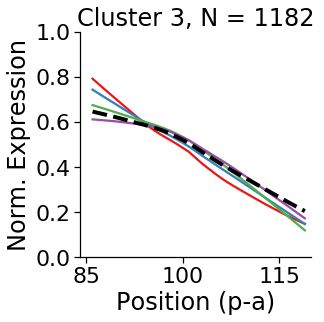

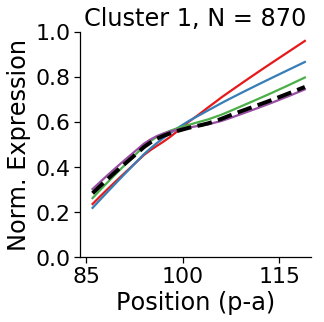

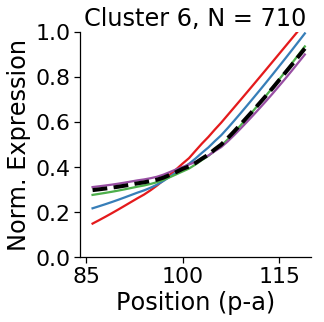

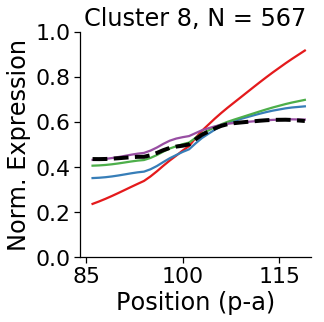

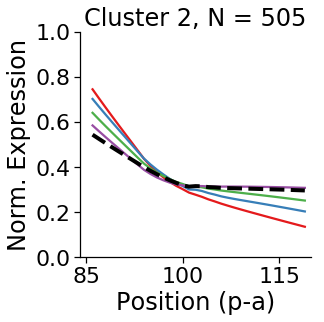

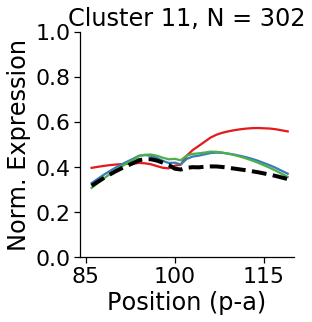

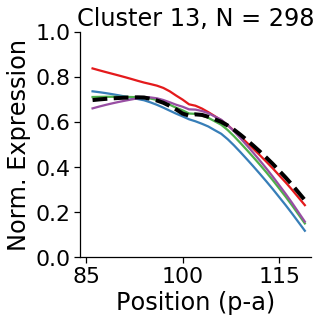

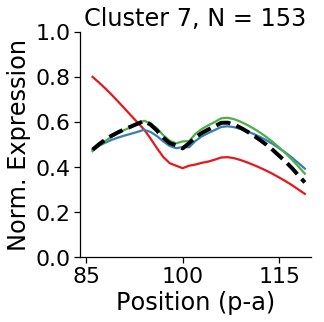

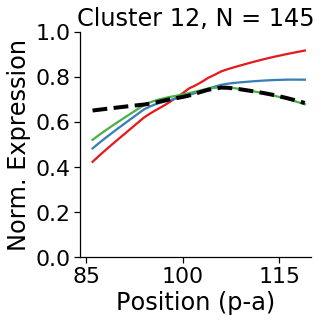

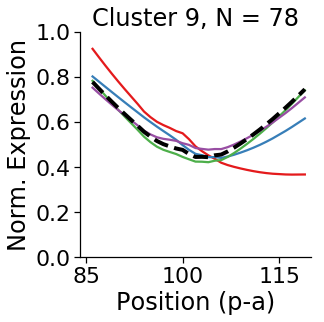

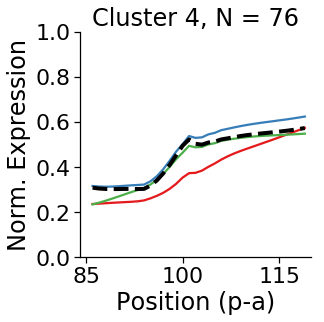

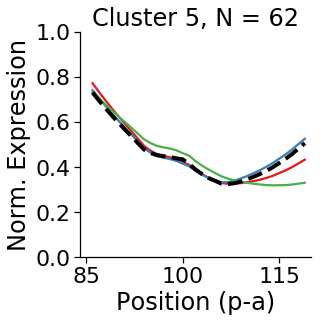

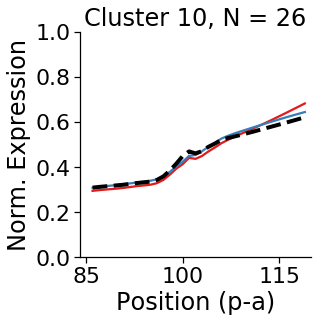

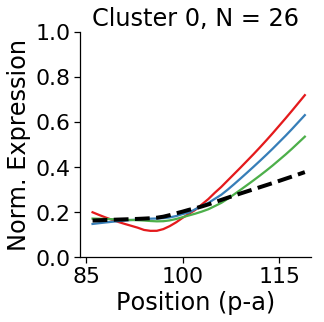

In [795]:
sns.set_context('notebook',font_scale=2)

for lab, n in mtx['label'].value_counts()[:-1].iteritems(): # if this doesn't work, delete the [:-1] at th end
    mini_matA = mtx[mtx['label']==lab]
    plt.close()
    fig = sns.lmplot(x='y', y='x', data=jnk[jnk.cluster==lab],lowess=True, col='cluster',
           markers='', hue='set', palette='Set1')
    fig._legend.remove()
    fig.set_xticklabels([85,100,115])
    sns.regplot(x=mtx.loc['ap'][:-1].values.astype(float),
                y = mini_matA[mtx.columns[:-1]].mean(0),
               lowess=True,
                marker='',
                color='black',
                line_kws = {'linewidth':4,'linestyle':'--'})
#     sns.regplot(x=mtx.loc['ap'][:-1].values.astype(float),
#                 y = mini_matB[mtx.columns[:-1]].mean(0),
#                lowess=True,
#                 marker='',
#                 color='black',
#                line_kws = {'linestyle':'--', 'linewidth':4})
    
    plt.xlim(84,120)
    plt.ylim(0,1)    
    plt.title('Cluster %s, N = %s'%(int(lab), n))
    plt.xlabel('Position (p-a)')
    plt.ylabel('Norm. Expression')
    plt.xticks([85,100,115])    
    #plt.savefig(os.path.join(fig_dir,'AllSets_C%s.pdf'%lab,
    #           bbox_inches='tight')
    plt.show()


#### Find proportion of expression clusters for each gene set

In [810]:
for gset in range(1,5):
    cset = cluster_sets[cluster_sets.Set==gset]
    vals = cset.N / cset.N.sum()
    cluster_sets.loc[cset.index,'Perc.'] = vals.values

In [811]:
cluster_sets.loc[:,'Set'] = cluster_sets.Set.astype(int)
cluster_sets.loc[:,'Cluster'] = cluster_sets.Cluster.astype(int)
cluster_sets.head()

Set  Cluster     N     Perc.
0    1        3  34.0  0.336634
1    1        6  27.0  0.267327
2    1        1  13.0  0.128713
3    1        2  12.0  0.118812
4    1        8  11.0  0.108911

#### plot it

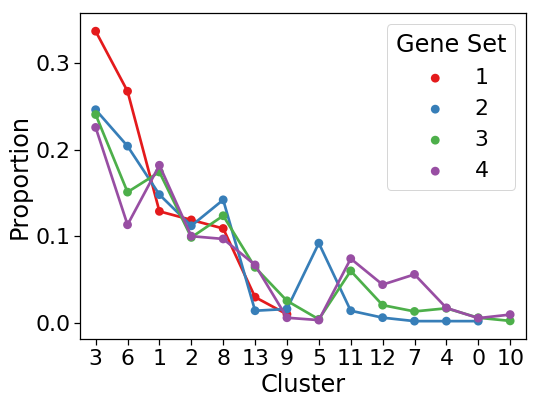

In [814]:
order = cluster_sets[cluster_sets.Set==1].sort_values('Perc.',ascending=False).Cluster.values.tolist() + [5,11,12,7,4,0,10]

plt.close()
plt.subplots(figsize=(8,6))
fig = sns.pointplot(x='Cluster',y='Perc.',hue='Set',data=cluster_sets, palette='Set1', 
                    order = order)
fig.set_xticklabels([int(x) for x in order])
fig.legend(title='Gene Set')
plt.ylabel('Proportion')
#plt.savefig(os.path.join('ClusProp_line.pdf'),
#           bbox_inches = 'tight')
plt.show()

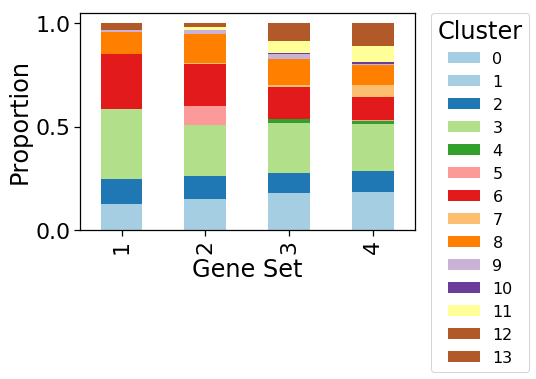

In [754]:
# an alternative visualization
pt = cluster_sets.groupby(['Set','Cluster','Perc.']).size().reset_index().pivot(columns='Cluster', index='Set', values='Perc.')
plt.close()
pt.plot(kind='bar',stacked=True,colormap='Paired')
plt.xlabel('Gene Set')
plt.ylabel('Proportion')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,title='Cluster',fontsize='16')
plt.show()

# Prep for cytoscape

I didn't end up putting the cytoscape stuff into the paper, but here's how I converted these spreadsheets into a format readable by Enrichment Map app for Cytoscape

In [919]:
comp = pandas.ExcelFile('/home/users/jvogel/git/Hippocampus_AP_Axis/Data/GOCOMPONENT_6_2700.xlsx')
comp.sheet_names

['GOCOMPONENT(1)']

In [946]:
comp = pandas.ExcelFile('/home/users/jvogel/git/Hippocampus_AP_Axis/Data/GOCOMPONENT_6_2700.xlsx').parse('GOCOMPONENT(1)')
func = pandas.ExcelFile('/home/users/jvogel/git/Hippocampus_AP_Axis/Data/GOFUNCTION_6_2700.xlsx').parse('GOFUNCTION(1)')
proc = pandas.ExcelFile('/home/users/jvogel/git/Hippocampus_AP_Axis/Data/GOPROCESS_6_2700.xlsx').parse('GOPROCESS(1)')

goset2 = pandas.concat([comp,func,proc],axis=0)
goset2.index = range(len(goset2))
goset2 = goset2.reindex(columns = goset2.columns.tolist() + ['col%s'%x for x in range(200)])
goset2.head()

GO Term                             Description       P-value  \
0  GO:0044459                    plasma membrane part  2.670000e-17   
1  GO:0031226  intrinsic component of plasma membrane  1.300000e-11   
2  GO:0043005                       neuron projection  9.300000e-11   
3  GO:0005887   integral component of plasma membrane  1.190000e-10   
4  GO:0097458                             neuron part  1.910000e-09   

    FDR q-value  Enrichment      N     B     n    b  \
0  5.230000e-14        1.56  17836  2675  1324  310   
1  1.270000e-08        1.64  17836  1443  1324  176   
2  6.080000e-08        1.79  17836   933  1324  124   
3  5.840000e-08        1.63  17836  1364  1324  165   
4  7.510000e-07        1.52  17836  1635  1324  185   

                                               Genes   ...    col190  col191  \
0  [TSPAN14  -  tetraspanin 14, PCDHB16  -  proto...   ...       NaN     NaN   
1  [TSPAN14  -  tetraspanin 14, FLT3  -  fms-rela...   ...       NaN     NaN   
2  [RELN  -  reelin, PDLIM5  -  pdz and lim domai...   ...       NaN     NaN   
3  [TSPAN14  -  tetraspanin 14, FLT3  -  fms-rela...   ...       NaN     NaN   
4  [RELN  -  reelin, PDLIM5  -  pdz and lim domai...   ...       NaN     NaN   

   col192  col193  col194  col195  col196  col197  col198  col199  
0     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
1     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
2     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
3     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
4     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  

[5 rows x 210 columns]

In [925]:
for i, row in goset2.iterrows():
    jnk = row['Genes':].dropna().tolist()
    jnk = [x.replace('[','').replace('[','').split(' - ')[0].strip() for x in jnk]
    genes = [x for x in jnk if x.isupper()]
#    jnk = row['Genes']
#    jnk = jnk.replace('[','')
#    jnk = jnk.replace(']','')
#    genes = [x for x in jnk.split(' ') if x.isupper()]
    goset2.loc[i,goset2.columns[10:10+len(genes)]] = genes

In [926]:
ncomp = goset2.drop(goset2.columns[2:10],axis=1)

In [927]:
ncomp.to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NCRevisions/GOSET3.gmt', sep='\t',
             header=False,index=False)

In [951]:
for i, row in goset2.iterrows():
    jnk = row['Genes':].dropna().tolist()[0].split(' ')
    genes = [x for x in jnk if x.isupper()]
    genes = [x[1:] if '[' in x or ']' in x else x for x in genes ]
#    jnk = row['Genes']
#    jnk = jnk.replace('[','')
#    jnk = jnk.replace(']','')
#    genes = [x for x in jnk.split(' ') if x.isupper()]
    ng = ''
    for g,gene in enumerate(genes):
        if g == len(genes)-1:
            ng += gene
        else:
            ng += gene+','
        
    goset2.loc[i,'Genes'] = ng

In [954]:
ncomp2 = goset2[goset2.columns[:10]]
ncomp2.columns = ['GO.ID','Description','p.Val','FDR'] + ncomp2.columns[4:].tolist()
ncomp2.to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NCRevisions/GOSET3_res.txt', index=False,
                                        sep='\t')